# Import packages


In [1]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings

# Load data


In [2]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


In [3]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 5
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

In [4]:
train_data, test_data, all_data, test_data_start_list = load_data(stock_name, date_predict_start, data_range, slide_range, n_slide)

In [5]:
all_data.iloc[23449]

Open            4.228290e+03
High            4.236390e+03
Low             4.188130e+03
Close           4.188430e+03
Volume          4.560700e+09
Dividends       0.000000e+00
Stock Splits    0.000000e+00
Name: 2021-05-10, dtype: float64

In [6]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0
...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0


# Data preprocessing


In [7]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [8]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [9]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [10]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # get harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [11]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            # for j in range(n_harm):
            for j in range(2, n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [12]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [13]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [14]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [15]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [16]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [17]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [18]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [19]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [20]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [21]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [22]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [23]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [24]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [25]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data_copy[d].index = test_data[d]['index']
        test_data_copy[d] = test_data_copy[d].drop(test_data_copy[d][test_data_copy[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data_copy :
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [26]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    # return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [27]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 5
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

In [28]:
# main_funtion(
#     stock_name, date_predict_start, data_range, slide_range,
#         n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)

In [29]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)


In [30]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [31]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.random import shuffle

In [32]:
def preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide):
    x_train = {}
    y_train = {}
    for i in train_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_data = scaler.fit_transform(train_data[i]['Close'].values.reshape(-1,1))
        x_train[i] = []
        y_train[i] = []
        for x in range(base_day+prediction_day, len(scaled_data)):
            x_train[i].append(scaled_data[x-base_day-prediction_day:x-prediction_day])
            y_train[i].append(scaled_data[x-prediction_day:x])
        x_train[i], y_train[i] = np.array(x_train[i]), np.array(y_train[i])
        # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
        x_train[i] = np.reshape(x_train[i], (x_train[i].shape[0], x_train[i].shape[1], 1))
        y_train[i] = np.reshape(y_train[i], (y_train[i].shape[0], y_train[i].shape[1], 1))
    return x_train, y_train

In [33]:
base_day = 10
prediction_day = base_day
slide = base_day

In [34]:
x_train, y_train = preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide)

In [35]:
x_train['data_0'].shape

(230, 10, 1)

In [36]:
def LSTM_model(prediction_day, input_shape):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))
    model.add(Dense(units=prediction_day))
    return model

In [37]:
input_shape = (x_train[list(x_train.keys())[0]].shape[1],1)

In [38]:
def build_Lstm_model(prediction_day, input_shape):
    model = {}
    for i in train_data:
        model[i] = LSTM_model(prediction_day, input_shape)
        model[i].compile(optimizer='adam', 
                    loss='mean_squared_error')
        # model[i].summary()
    return model

In [39]:
model = build_Lstm_model(prediction_day, input_shape)

In [40]:
from tqdm import tqdm

In [41]:
def train_Lstm_model():
    history = {}
    for i in tqdm(train_data):
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history[i] = model[i].fit(x_train[i], y_train[i], epochs=25, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
    return history

In [42]:
history = train_Lstm_model()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
6/6 [==============================] - 16s 866ms/step - loss: 0.0483 - val_loss: 0.2048
Epoch 2/25
6/6 [==============================] - 0s 82ms/step - loss: 0.0314 - val_loss: 0.1180
Epoch 3/25
6/6 [==============================] - 1s 88ms/step - loss: 0.0281 - val_loss: 0.1601
Epoch 4/25
6/6 [==============================] - 0s 85ms/step - loss: 0.0244 - val_loss: 0.1347
Epoch 5/25
6/6 [==============================] - 0s 83ms/step - loss: 0.0238 - val_loss: 0.1524
Epoch 6/25
6/6 [==============================] - 0s 70ms/step - loss: 0.0235 - val_loss: 0.1514
Epoch 7/25
6/6 [==============================] - 0s 63ms/step - loss: 0.0222 - val_loss: 0.1565
Epoch 7: early stopping


 10%|█         | 1/10 [00:19<02:52, 19.15s/it]

Epoch 1/25
6/6 [==============================] - 12s 768ms/step - loss: 0.0621 - val_loss: 0.2520
Epoch 2/25
6/6 [==============================] - 0s 82ms/step - loss: 0.0402 - val_loss: 0.2393
Epoch 3/25
6/6 [==============================] - 0s 74ms/step - loss: 0.0370 - val_loss: 0.1804
Epoch 4/25
6/6 [==============================] - 0s 74ms/step - loss: 0.0321 - val_loss: 0.1658
Epoch 5/25
6/6 [==============================] - 0s 76ms/step - loss: 0.0304 - val_loss: 0.1793
Epoch 6/25
6/6 [==============================] - 0s 74ms/step - loss: 0.0298 - val_loss: 0.1953
Epoch 7/25
6/6 [==============================] - 0s 76ms/step - loss: 0.0294 - val_loss: 0.2196
Epoch 8/25
6/6 [==============================] - 0s 72ms/step - loss: 0.0280 - val_loss: 0.2218
Epoch 9/25
6/6 [==============================] - 0s 73ms/step - loss: 0.0291 - val_loss: 0.2203
Epoch 9: early stopping


 20%|██        | 2/10 [00:34<02:14, 16.78s/it]

Epoch 1/25
6/6 [==============================] - 13s 459ms/step - loss: 0.1223 - val_loss: 0.2739
Epoch 2/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0597 - val_loss: 0.2666
Epoch 3/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0536 - val_loss: 0.2302
Epoch 4/25
6/6 [==============================] - 0s 74ms/step - loss: 0.0455 - val_loss: 0.2260
Epoch 5/25
6/6 [==============================] - 0s 67ms/step - loss: 0.0430 - val_loss: 0.2054
Epoch 6/25
6/6 [==============================] - 0s 63ms/step - loss: 0.0432 - val_loss: 0.1962
Epoch 7/25
6/6 [==============================] - 0s 64ms/step - loss: 0.0402 - val_loss: 0.1983
Epoch 8/25
6/6 [==============================] - 0s 62ms/step - loss: 0.0421 - val_loss: 0.2094
Epoch 9/25
6/6 [==============================] - 0s 62ms/step - loss: 0.0410 - val_loss: 0.2264
Epoch 10/25
6/6 [==============================] - 0s 79ms/step - loss: 0.0398 - val_loss: 0.2209
Epoch 11/25
6/6 [==========

 30%|███       | 3/10 [00:53<02:04, 17.76s/it]

Epoch 1/25
6/6 [==============================] - 13s 445ms/step - loss: 0.1656 - val_loss: 0.2367
Epoch 2/25
6/6 [==============================] - 0s 64ms/step - loss: 0.0701 - val_loss: 0.2193
Epoch 3/25
6/6 [==============================] - 0s 62ms/step - loss: 0.0628 - val_loss: 0.2180
Epoch 4/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0508 - val_loss: 0.1669
Epoch 5/25
6/6 [==============================] - 0s 83ms/step - loss: 0.0495 - val_loss: 0.1513
Epoch 6/25
6/6 [==============================] - 0s 62ms/step - loss: 0.0466 - val_loss: 0.1352
Epoch 7/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0441 - val_loss: 0.1019
Epoch 8/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0441 - val_loss: 0.0924
Epoch 9/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0411 - val_loss: 0.0776
Epoch 10/25
6/6 [==============================] - 0s 63ms/step - loss: 0.0385 - val_loss: 0.0808
Epoch 11/25
6/6 [==========

 40%|████      | 4/10 [01:17<02:02, 20.46s/it]

Epoch 1/25
6/6 [==============================] - 11s 519ms/step - loss: 0.1401 - val_loss: 0.2883
Epoch 2/25
6/6 [==============================] - 0s 75ms/step - loss: 0.0621 - val_loss: 0.2898
Epoch 3/25
6/6 [==============================] - 0s 81ms/step - loss: 0.0551 - val_loss: 0.2267
Epoch 4/25
6/6 [==============================] - 0s 85ms/step - loss: 0.0477 - val_loss: 0.1674
Epoch 5/25
6/6 [==============================] - 0s 75ms/step - loss: 0.0432 - val_loss: 0.1431
Epoch 6/25
6/6 [==============================] - 0s 83ms/step - loss: 0.0409 - val_loss: 0.0836
Epoch 7/25
6/6 [==============================] - 0s 75ms/step - loss: 0.0386 - val_loss: 0.0648
Epoch 8/25
6/6 [==============================] - 1s 91ms/step - loss: 0.0387 - val_loss: 0.0520
Epoch 9/25
6/6 [==============================] - 0s 77ms/step - loss: 0.0367 - val_loss: 0.0452
Epoch 10/25
6/6 [==============================] - 0s 79ms/step - loss: 0.0366 - val_loss: 0.0458
Epoch 11/25
6/6 [==========

 50%|█████     | 5/10 [01:36<01:39, 19.83s/it]

Epoch 1/25
6/6 [==============================] - 16s 407ms/step - loss: 0.0509 - val_loss: 0.2033
Epoch 2/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0270 - val_loss: 0.1128
Epoch 3/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0232 - val_loss: 0.1796
Epoch 4/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0211 - val_loss: 0.1336
Epoch 5/25
6/6 [==============================] - 0s 82ms/step - loss: 0.0213 - val_loss: 0.3224
Epoch 6/25
6/6 [==============================] - 0s 64ms/step - loss: 0.0209 - val_loss: 0.1740
Epoch 7/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0201 - val_loss: 0.5241
Epoch 7: early stopping


 60%|██████    | 6/10 [01:54<01:16, 19.17s/it]

Epoch 1/25
6/6 [==============================] - 17s 511ms/step - loss: 0.1091 - val_loss: 0.2927
Epoch 2/25
6/6 [==============================] - 0s 69ms/step - loss: 0.0353 - val_loss: 0.2530
Epoch 3/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0278 - val_loss: 0.2739
Epoch 4/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0207 - val_loss: 0.2578
Epoch 5/25
6/6 [==============================] - 0s 65ms/step - loss: 0.0176 - val_loss: 0.3308
Epoch 6/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0173 - val_loss: 0.2696
Epoch 7/25
6/6 [==============================] - 0s 52ms/step - loss: 0.0172 - val_loss: 0.3062
Epoch 7: early stopping


 70%|███████   | 7/10 [02:13<00:57, 19.28s/it]

Epoch 1/25
6/6 [==============================] - 13s 753ms/step - loss: 0.1285 - val_loss: 0.3264
Epoch 2/25
6/6 [==============================] - 0s 71ms/step - loss: 0.0359 - val_loss: 0.3119
Epoch 3/25
6/6 [==============================] - 1s 88ms/step - loss: 0.0305 - val_loss: 0.3340
Epoch 4/25
6/6 [==============================] - 0s 83ms/step - loss: 0.0242 - val_loss: 0.3336
Epoch 5/25
6/6 [==============================] - 1s 91ms/step - loss: 0.0212 - val_loss: 0.3565
Epoch 6/25
6/6 [==============================] - 0s 82ms/step - loss: 0.0192 - val_loss: 0.3483
Epoch 7/25
6/6 [==============================] - 1s 99ms/step - loss: 0.0178 - val_loss: 0.3806
Epoch 7: early stopping


 80%|████████  | 8/10 [02:30<00:36, 18.31s/it]

Epoch 1/25
6/6 [==============================] - 11s 470ms/step - loss: 0.1662 - val_loss: 0.3052
Epoch 2/25
6/6 [==============================] - 0s 73ms/step - loss: 0.0505 - val_loss: 0.3285
Epoch 3/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0380 - val_loss: 0.3061
Epoch 4/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0268 - val_loss: 0.4143
Epoch 5/25
6/6 [==============================] - 0s 70ms/step - loss: 0.0236 - val_loss: 0.3253
Epoch 6/25
6/6 [==============================] - 0s 72ms/step - loss: 0.0206 - val_loss: 0.3854
Epoch 6: early stopping


 90%|█████████ | 9/10 [02:44<00:17, 17.22s/it]

Epoch 1/25
6/6 [==============================] - 16s 479ms/step - loss: 0.2003 - val_loss: 0.2305
Epoch 2/25
6/6 [==============================] - 0s 61ms/step - loss: 0.0613 - val_loss: 0.3487
Epoch 3/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0451 - val_loss: 0.2661
Epoch 4/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0362 - val_loss: 0.4007
Epoch 5/25
6/6 [==============================] - 0s 66ms/step - loss: 0.0307 - val_loss: 0.3163
Epoch 6/25
6/6 [==============================] - 0s 64ms/step - loss: 0.0290 - val_loss: 0.3521
Epoch 6: early stopping


100%|██████████| 10/10 [03:03<00:00, 18.31s/it]


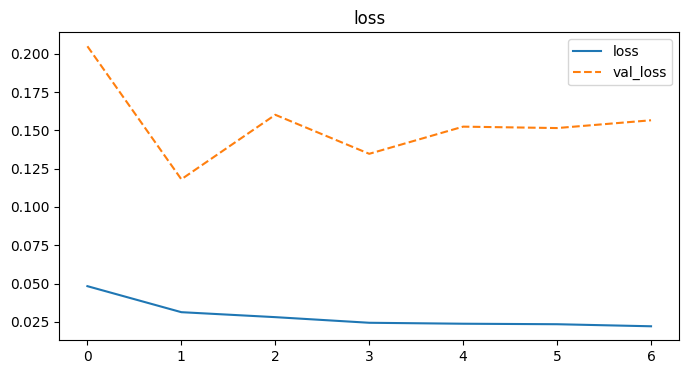

In [43]:
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history['data_0'].history['loss'], label='loss')
plt.plot(history['data_0'].history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()


In [44]:
def preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide):
    x_test = {}
    y_test = {}
    for i in test_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        model_inputs = pd.concat((train_data[i]['Close'].iloc[-base_day:], test_data[i]['Close'])).values
        model_inputs = model_inputs.reshape(-1,1)
        model_inputs = scaler.fit_transform(model_inputs)
        x_test[i] = []
        y_test[i] = []
        for x in range(base_day+prediction_day, len(model_inputs), slide):
            x_test[i].append(model_inputs[x-base_day-prediction_day:x-prediction_day])
            y_test[i].append(model_inputs[x-prediction_day:x])
        x_test[i], y_test[i] = np.array(x_test[i]), np.array(y_test[i])
        x_test[i] = np.reshape(x_test[i], (x_test[i].shape[0], x_test[i].shape[1], 1))
        y_test[i] = np.reshape(y_test[i], (y_test[i].shape[0], y_test[i].shape[1], 1))
    return x_test, y_test

In [45]:
x_test, y_test = preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide)

In [46]:
test_data['data_2']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-01-31,3282.330078,3282.330078,3214.679932,3225.520020,4529700000,0.0,0.0,NaN,3225.52002,valley
1,2020-02-03,3235.659912,3268.439941,3235.659912,3248.919922,3760460000,0.0,0.0,NaN,NaN,NaN
2,2020-02-04,3280.610107,3306.919922,3280.610107,3297.590088,3996900000,0.0,0.0,NaN,NaN,NaN
3,2020-02-05,3324.909912,3337.580078,3313.750000,3334.689941,4121480000,0.0,0.0,NaN,NaN,NaN
4,2020-02-06,3344.919922,3347.959961,3334.389893,3345.780029,3887250000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-01-21,3857.459961,3861.449951,3845.050049,3853.070068,4501760000,0.0,0.0,NaN,NaN,NaN
246,2021-01-22,3844.239990,3852.310059,3830.409912,3841.469971,5110890000,0.0,0.0,NaN,NaN,NaN
247,2021-01-25,3851.679932,3859.229980,3797.159912,3855.360107,7000840000,0.0,0.0,3855.360107,NaN,peak
248,2021-01-26,3862.959961,3870.899902,3847.780029,3849.620117,6137500000,0.0,0.0,NaN,NaN,NaN


In [47]:
def predicting_creat_processed_signal_Lstm(x_test, test_data):
    processed_signal = {}
    for i in test_data:
        predicted_prices = model[i].predict(x_test[i])
        processed_signal[i] = {}
        processed_signal[i][0] = pd.DataFrame(
            {'Close': predicted_prices.flatten()}, index=test_data[i].index[:len(predicted_prices.flatten())])
    return processed_signal

In [48]:
processed_signal = predicting_creat_processed_signal_Lstm(x_test, test_data)

1/1 [==============================] - 2s 2s/step


In [49]:
processed_signal['data_0'][0]

,Close
0,0.217686
1,0.213926
2,0.203058
3,0.217647
4,0.182362
...,...
235,0.357318
236,0.341669
237,0.251908
238,0.279438


In [50]:
# 3. Build model
# harmonics, model = build_model(
    # train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
# harmonics = data_to_harmonics_function(train_data, data_range)
# processed_signal_FFT = mix_harmonics_function(
#     harmonics, n_harm_lower_limit, n_harm_upper_limit)


In [51]:
# processed_signal = processed_signal_FFT

In [52]:
find_signal_pv_function(processed_signal, pv_range)
find_signal_lead_train_function(train_data, processed_signal)

In [53]:
# 4. Select model
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
#                                                                         model, fit_method)
errors = get_fit_error_function(processed_signal, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    processed_signal, errors)
find_signal_lead_test_function(test_data, processed_signal)
first_date, lead, pv = get_first_lead_function(
    processed_signal, best_fit_harm)


In [54]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [55]:
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)

In [56]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [57]:
def result_table_process_Lstm_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i]].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [58]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

            s_date t_date lead ans_date      pv error best_fit
data_0  2020-01-02    NaN -8.0      NaN  valley  8.67        0
data_1  2020-01-16    NaN  2.0      NaN  valley  8.78        0
data_2  2020-01-31    NaN -8.0      NaN  valley  8.24        0
data_3  2020-02-14    NaN -4.0      NaN  valley  7.74        0
data_4  2020-03-02    NaN -7.0      NaN    peak  8.89        0
data_5  2020-03-16    NaN  1.0      NaN    peak  8.46        0
data_6  2020-03-30    NaN  8.0      NaN    peak  7.44        0
data_7  2020-04-14    NaN -1.0      NaN  valley  7.13        0
data_8  2020-04-28    NaN  1.0      NaN  valley  7.37        0
data_9  2020-05-12    NaN -2.0      NaN  valley  6.96        0


In [59]:
result_table_process_Lstm_function(
    result_table, all_data, first_date, data_range)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

            s_date      t_date lead    ans_date      pv error best_fit
data_0  2020-01-02  2020-01-15 -8.0  2020-01-03  valley  8.67        0
data_1  2020-01-16  2020-01-29  2.0  2020-01-31  valley  8.78        0
data_2  2020-01-31  2020-02-12 -8.0  2020-01-31  valley  8.24        0
data_3  2020-02-14  2020-03-05 -4.0  2020-02-28  valley  7.74        0
data_4  2020-03-02  2020-03-13 -7.0  2020-03-04    peak  8.89        0
data_5  2020-03-16  2020-03-25  1.0  2020-03-26    peak  8.46        0
data_6  2020-03-30  2020-04-06  8.0  2020-04-17    peak  7.44        0
data_7  2020-04-14  2020-04-22 -1.0  2020-04-21  valley  7.13        0
data_8  2020-04-28  2020-04-30  1.0  2020-05-01  valley  7.37        0
data_9  2020-05-12  2020-05-15 -2.0  2020-05-13  valley  6.96        0


In [60]:
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  4.2
            s_date      t_date lead    ans_date      pv error best_fit
data_0  2020-01-02  2020-01-15 -8.0  2020-01-03  valley  8.67        0
data_1  2020-01-16  2020-01-29  2.0  2020-01-31  valley  8.78        0
data_2  2020-01-31  2020-02-12 -8.0  2020-01-31  valley  8.24        0
data_3  2020-02-14  2020-03-05 -4.0  2020-02-28  valley  7.74        0
data_4  2020-03-02  2020-03-13 -7.0  2020-03-04    peak  8.89        0
data_5  2020-03-16  2020-03-25  1.0  2020-03-26    peak  8.46        0
data_6  2020-03-30  2020-04-06  8.0  2020-04-17    peak  7.44        0
data_7  2020-04-14  2020-04-22 -1.0  2020-04-21  valley  7.13        0
data_8  2020-04-28  2020-04-30  1.0  2020-05-01  valley  7.37        0
data_9  2020-05-12  2020-05-15 -2.0  2020-05-13  valley  6.96        0


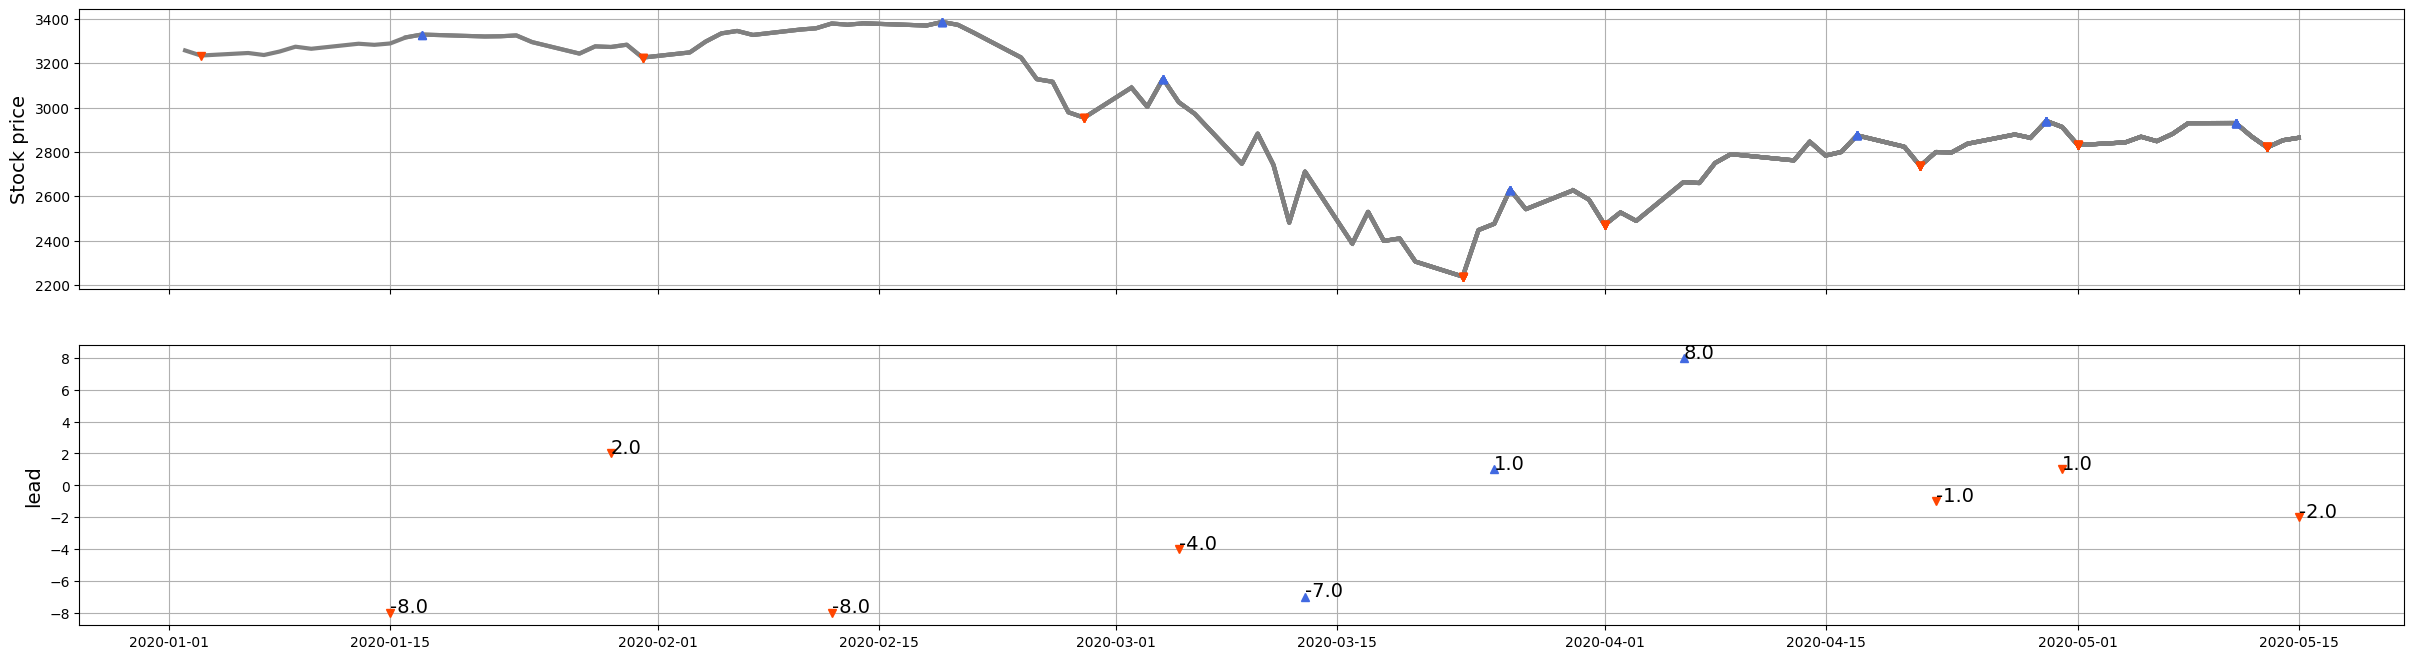

In [61]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

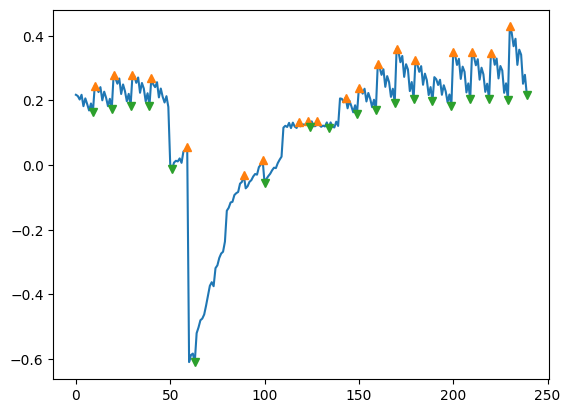

In [62]:
plt.plot(processed_signal['data_0'][0]['Close'])
plt.plot(processed_signal['data_0'][0]['peaks'], '^')
plt.plot(processed_signal['data_0'][0]['valleys'], 'v')

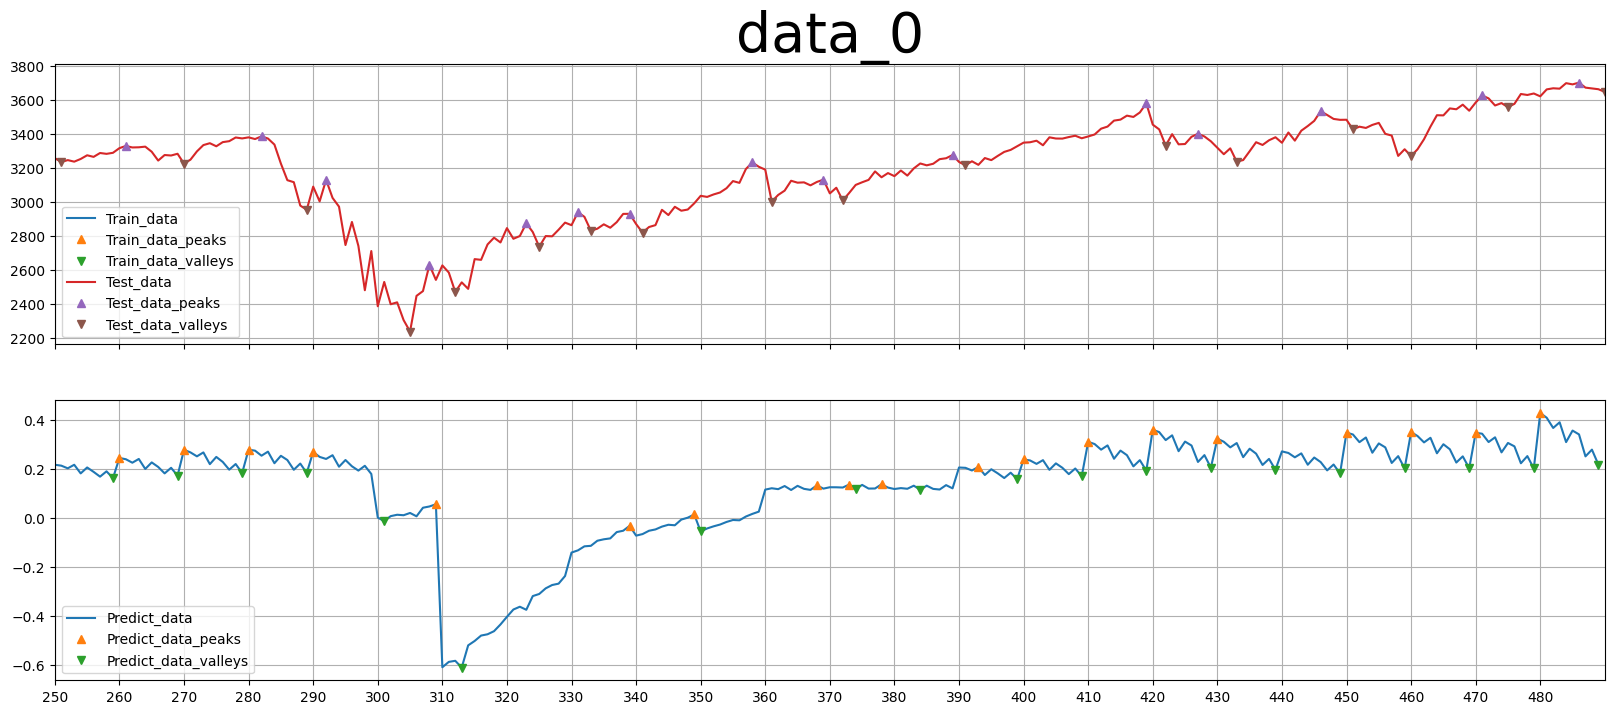

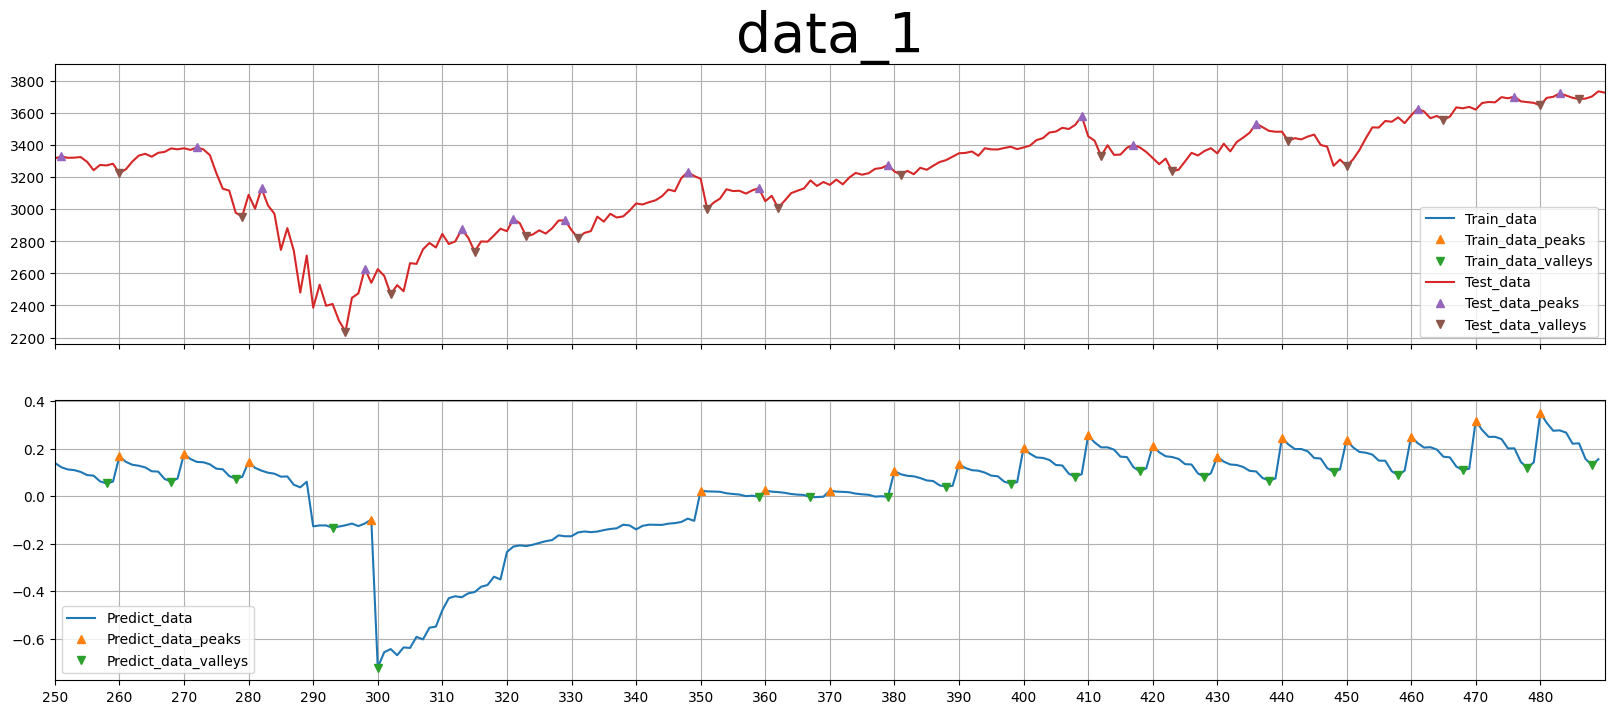

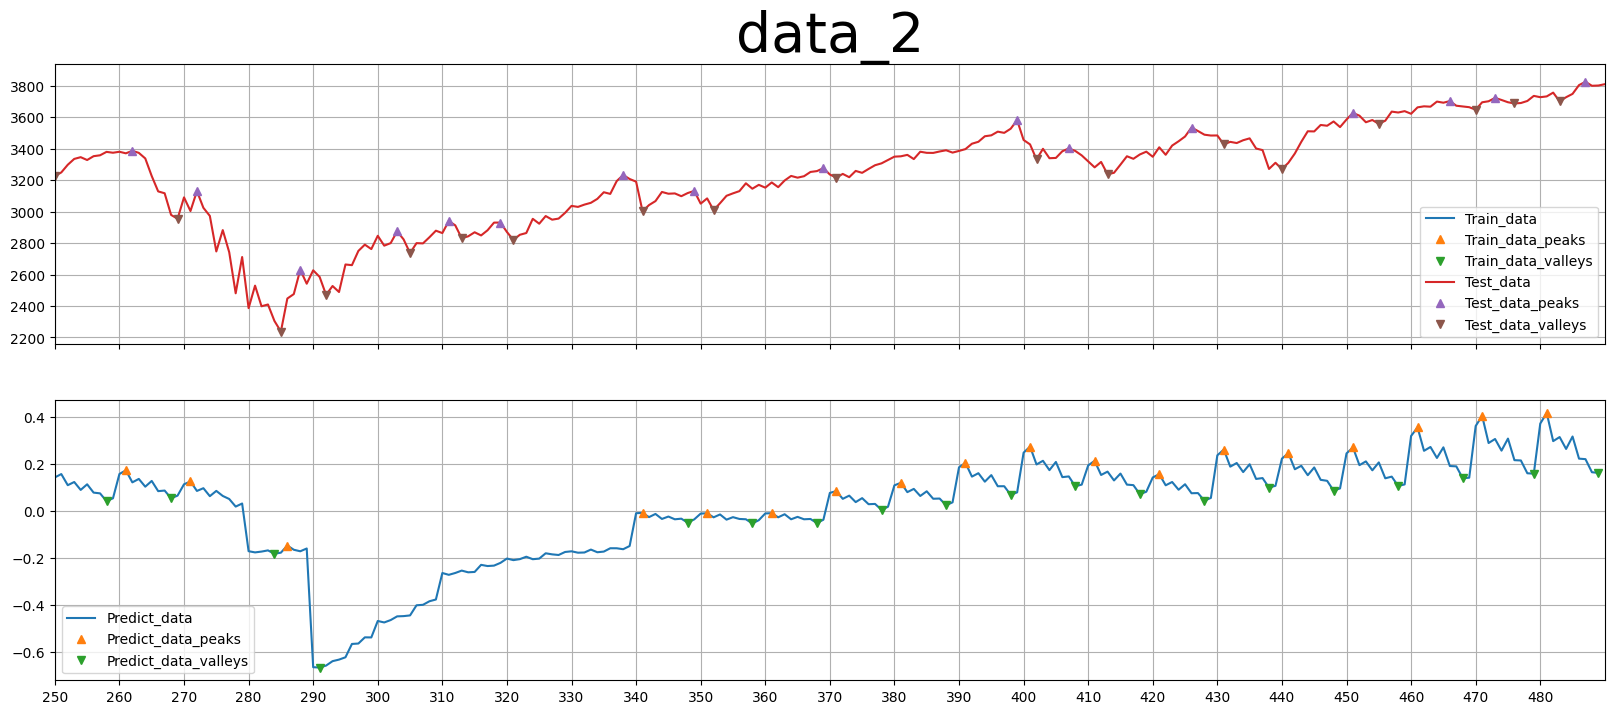

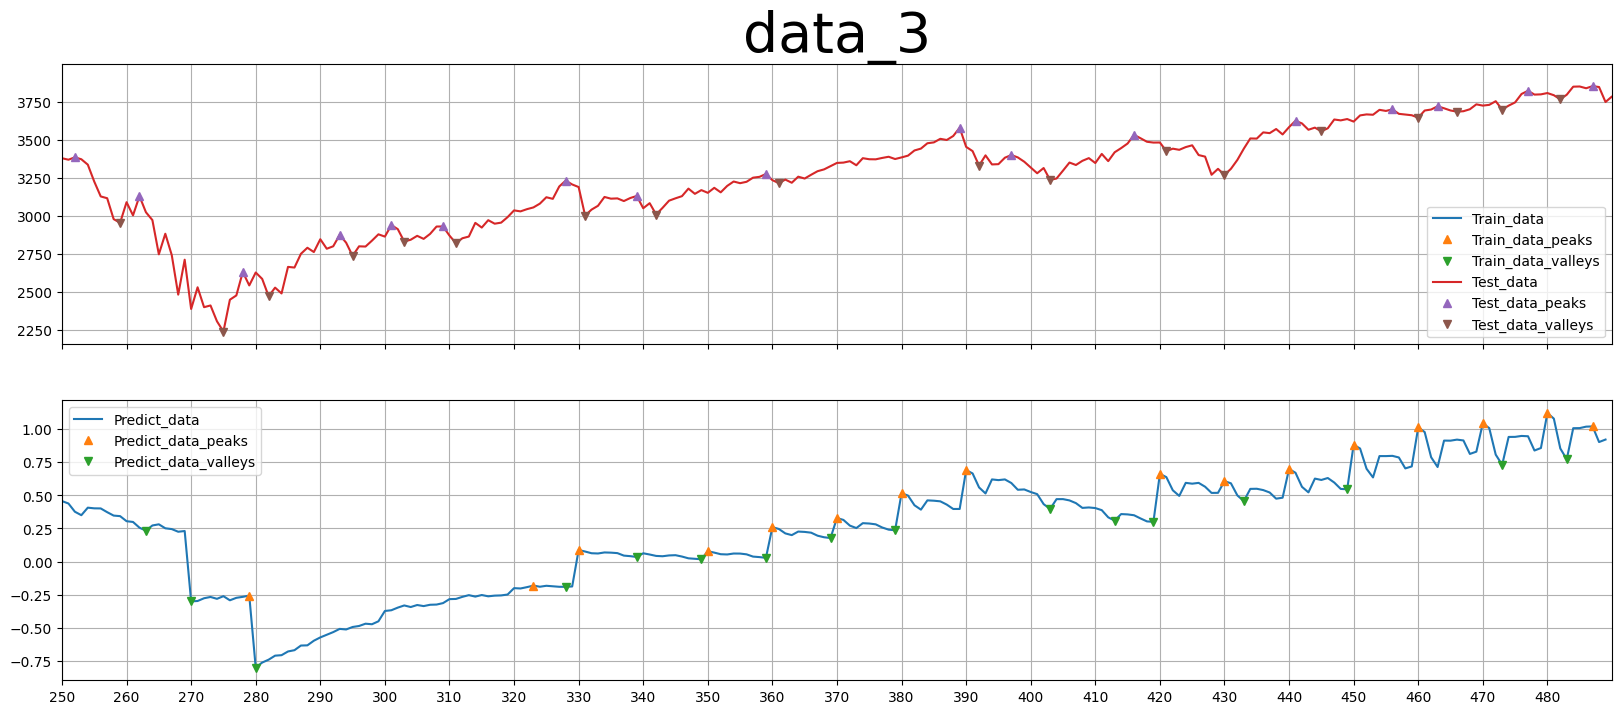

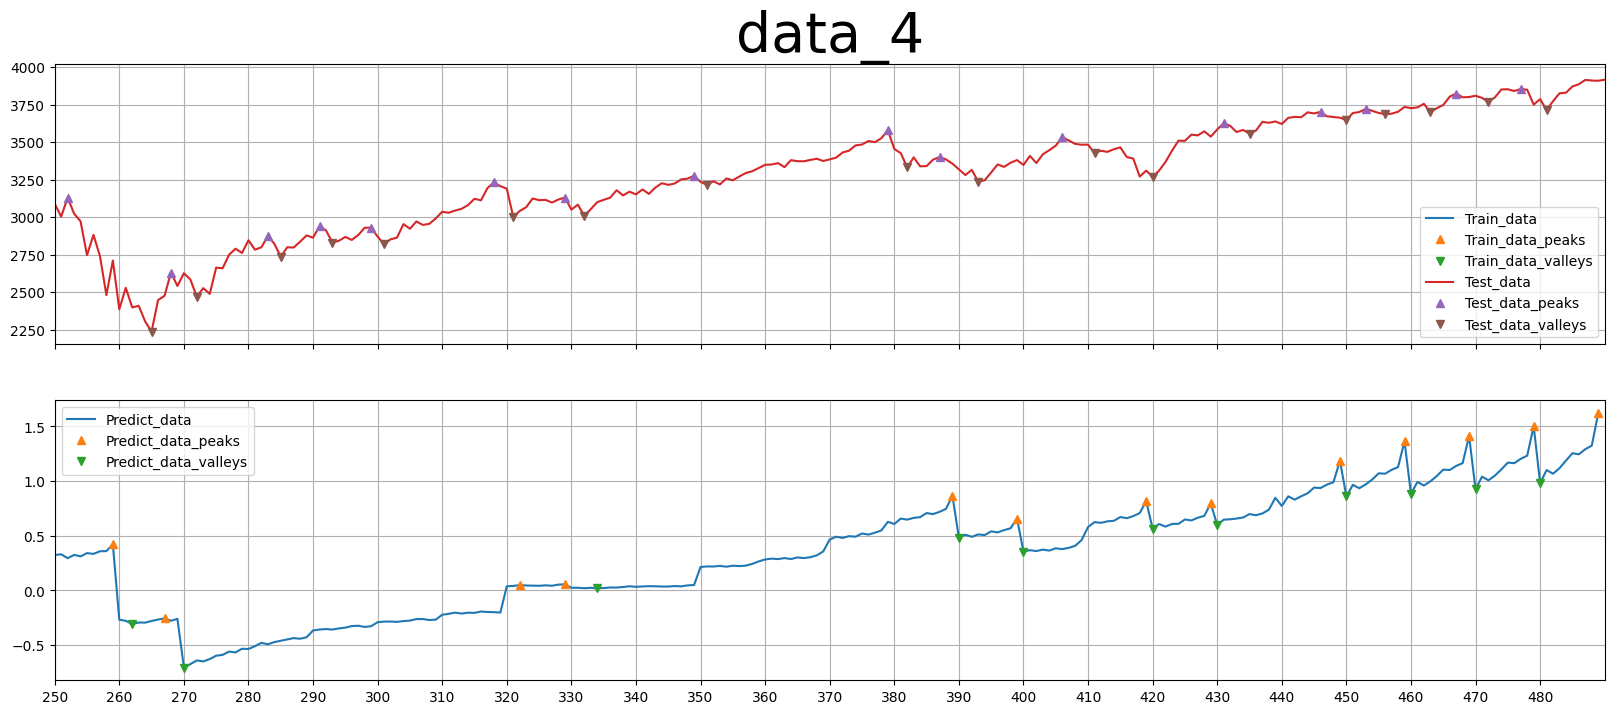

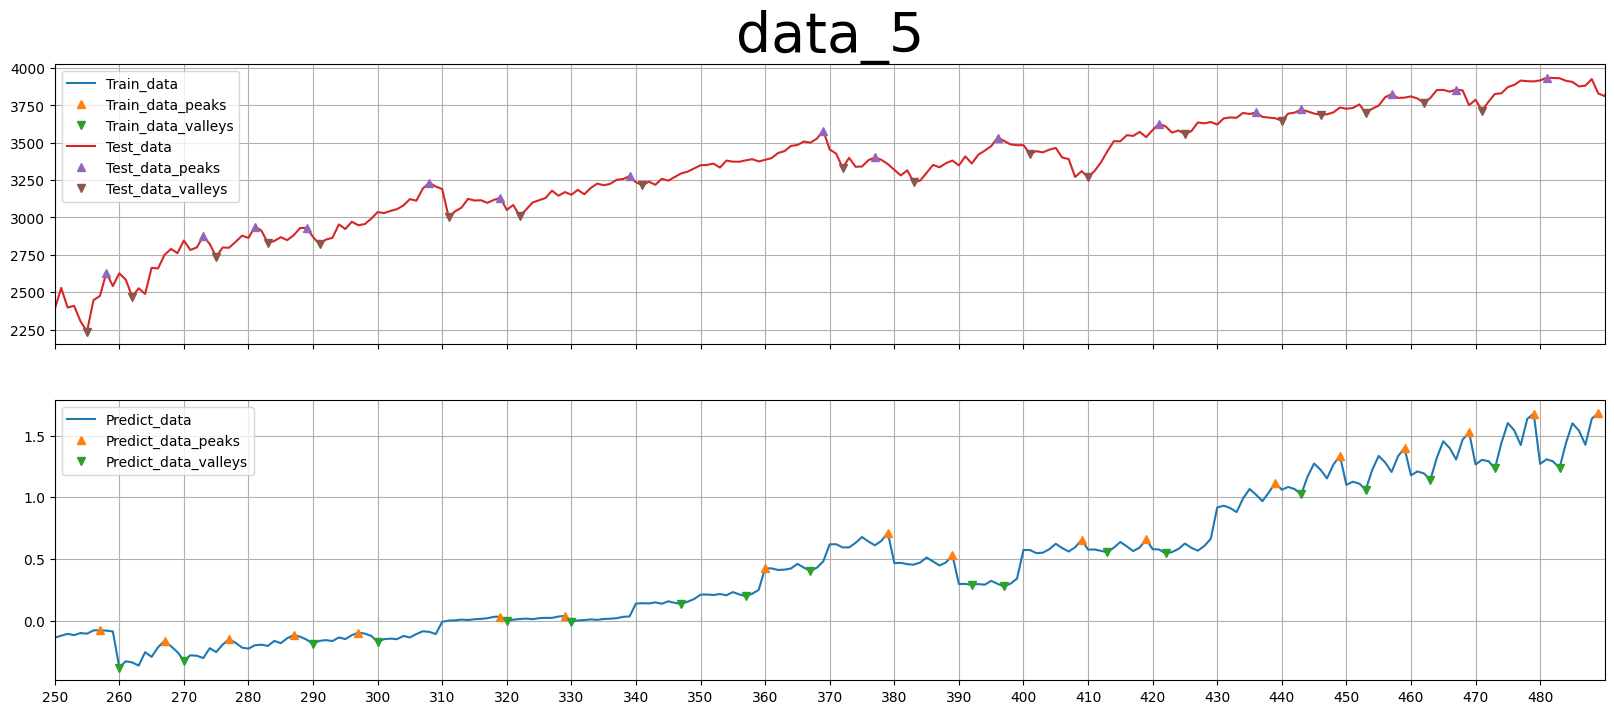

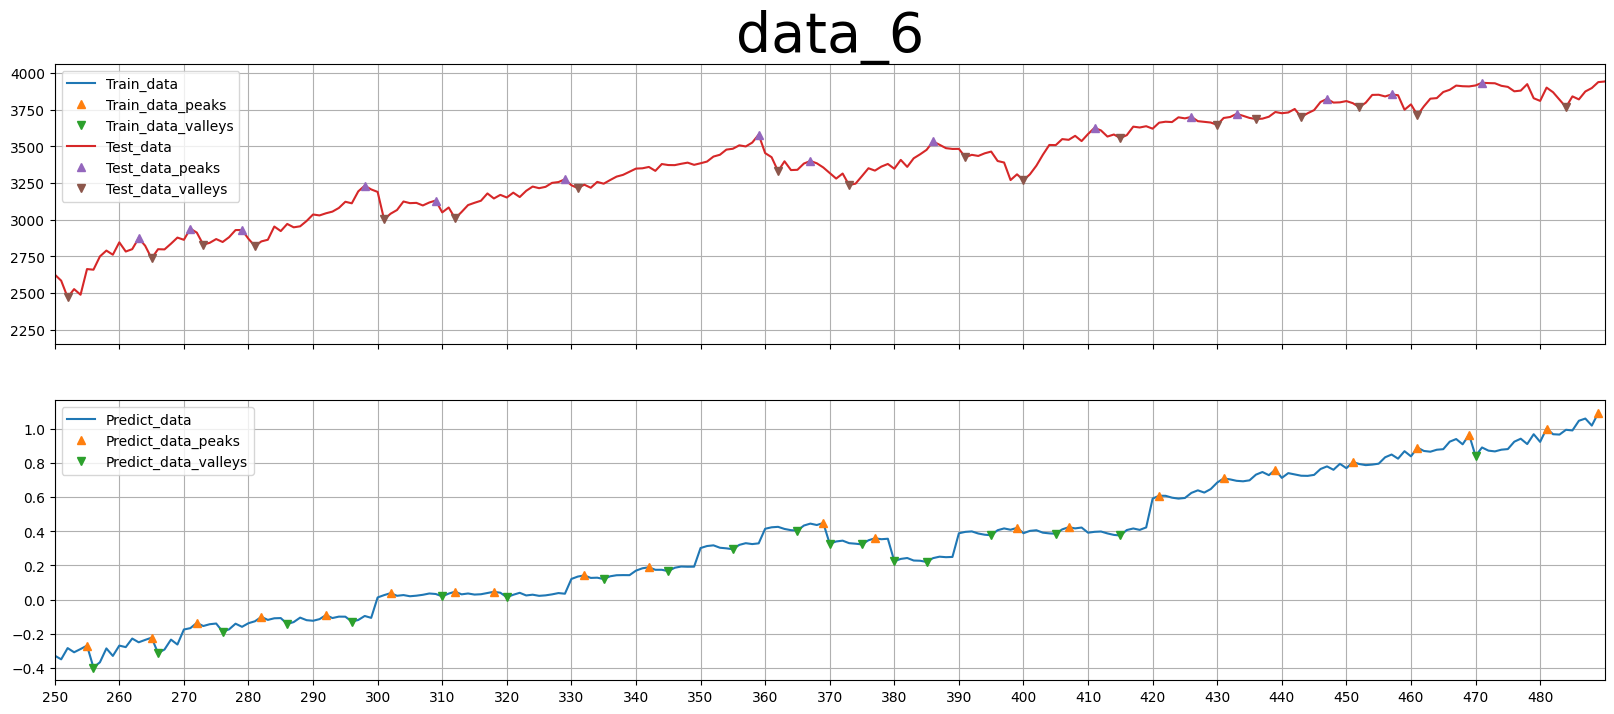

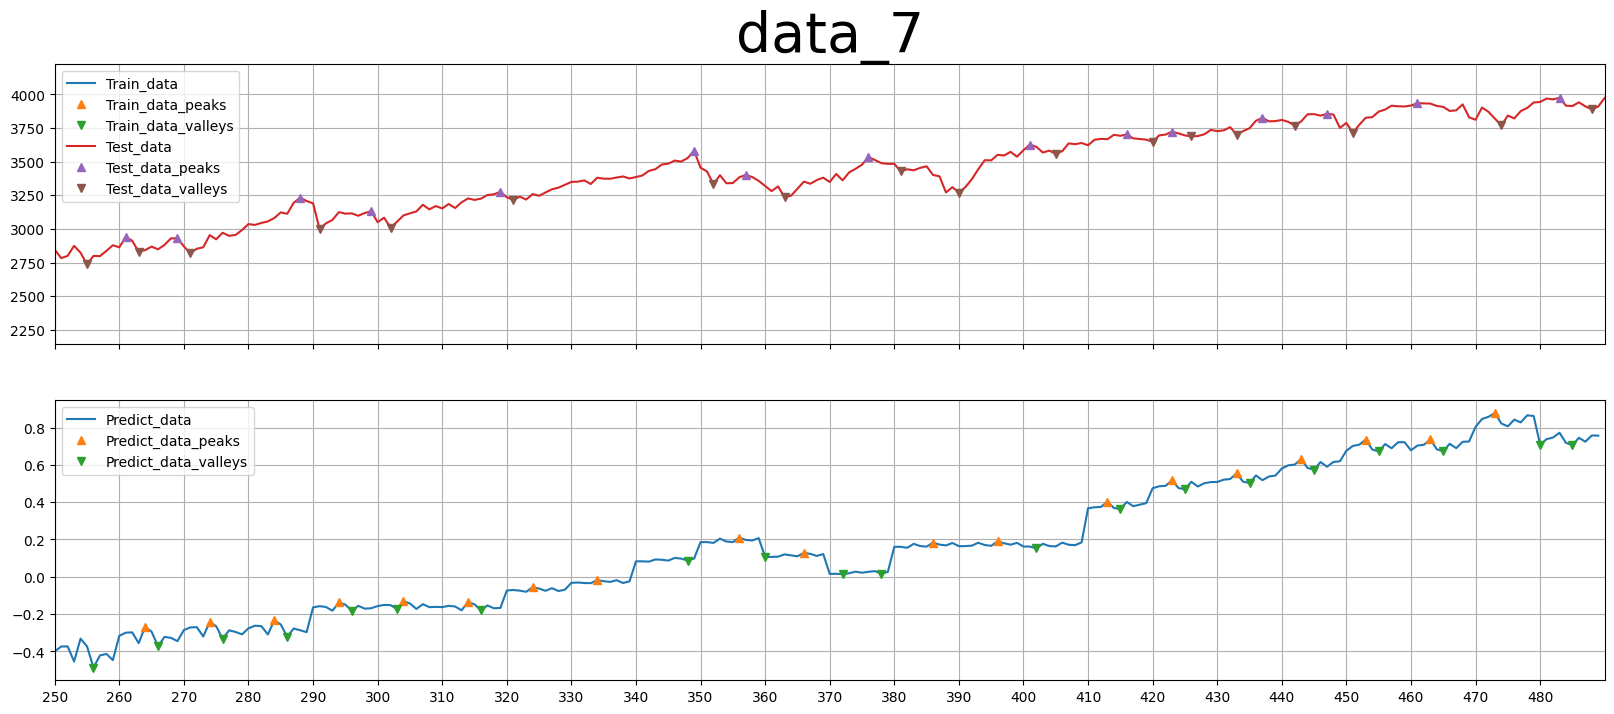

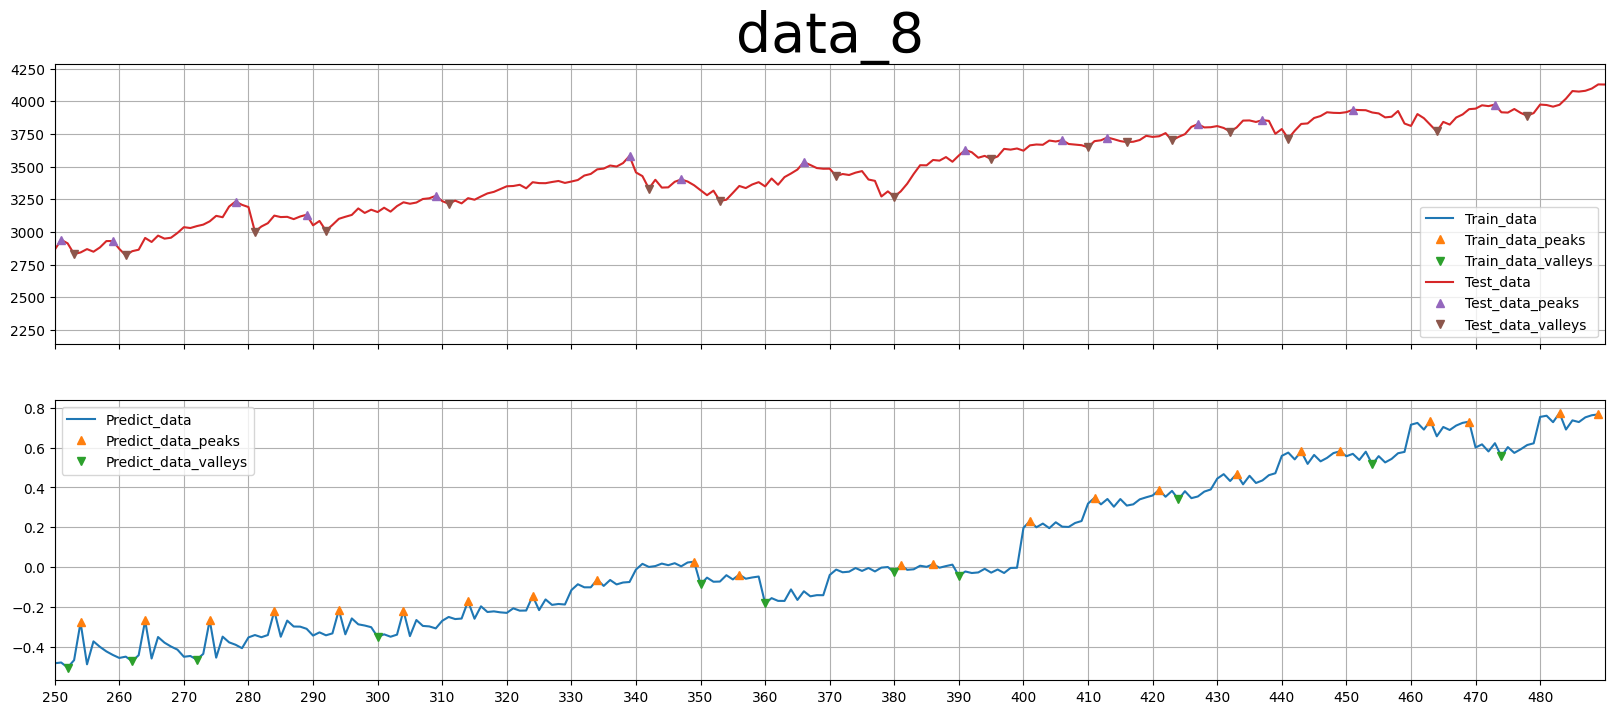

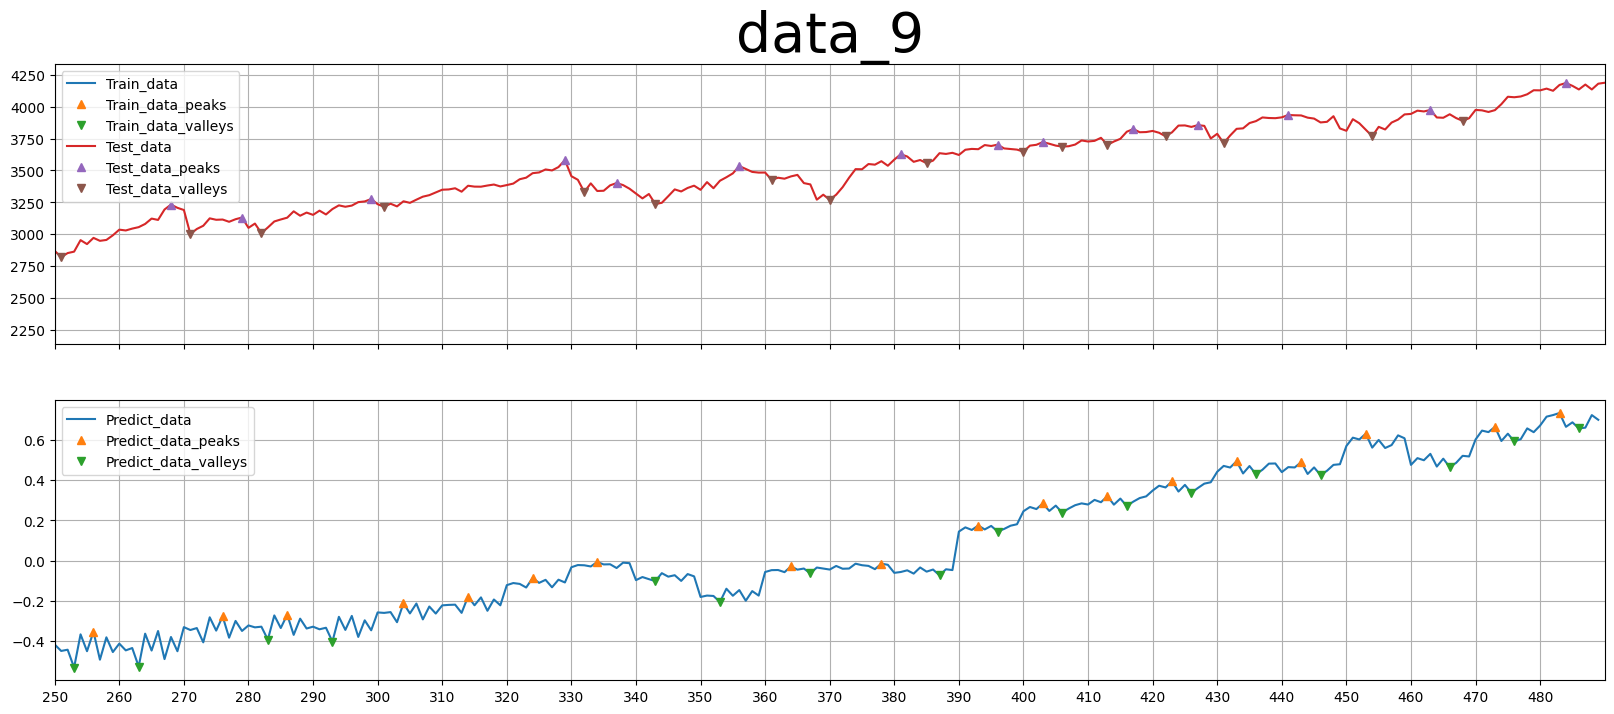

In [63]:
for i in processed_signal:
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['Close'], label='Train_data')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['peaks'], '^', label='Train_data_peaks')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['valleys'], 'v', label='Train_data_valleys')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['Close'], label='Test_data')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['peaks'], '^', label='Test_data_peaks')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['valleys'], 'v', label='Test_data_valleys')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['Close'], label='Predict_data')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['peaks'], '^', label='Predict_data_peaks')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['valleys'], 'v', label='Predict_data_valleys')
    plt.xlim(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]))
    axes[0].grid()
    axes[1].grid()
    axes[0].legend()
    axes[1].legend()
    plt.xticks(np.arange(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]), step=10))
    plt.show()

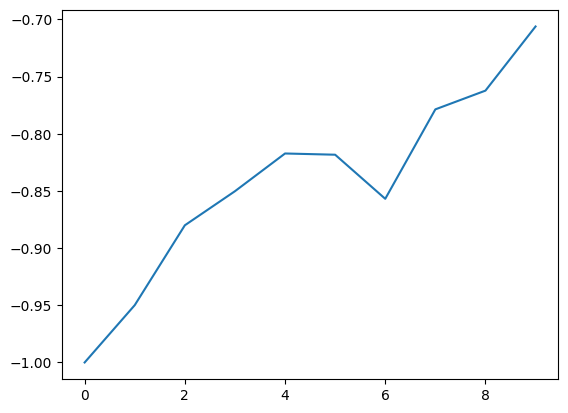

In [64]:
plt.plot(x_train['data_0'][0])

In [65]:
x_train['data_0'].shape[1]

10

In [66]:
for j in range(0, x_train[i].shape[1]):
    print(j)

0
1
2
3
4
5
6
7
8
9


In [67]:
len(x_train[i][0])

10

In [68]:
# x_start = 0
# x_end = x_start+slide
# for i in x_train:
#     x_start_copy = x_start
#     fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
#     axes[0].set_title(i, fontsize=40)
#     for j in range(0, x_train[i].shape[0]):
#         axes[0].plot(range(x_start, x_end), x_train[i][j], label=f'x_train_{j}')
#         axes[1].plot(range(x_end, x_end+slide), y_train[i][j], label=f'y_train_{j}')
#         x_start+=slide
#         x_end+=slide
#     axes[0].grid()
#     axes[1].grid()
#     axes[0].legend()
#     axes[1].legend()
#     plt.xticks(np.arange(x_start_copy, x_end, step=10))
#     plt.show()

In [69]:
processed_signal['data_0'][0]['Close'].values

array([ 0.21768636,  0.21392639,  0.20305781,  0.21764676,  0.18236247,
        0.20656663,  0.18859477,  0.16905929,  0.1907578 ,  0.16298911,
        0.24549887,  0.24017504,  0.22606592,  0.2413714 ,  0.20050448,
        0.22725709,  0.20871086,  0.18245052,  0.20526361,  0.17307019,
        0.2786749 ,  0.2681528 ,  0.25203353,  0.2680847 ,  0.22018062,
        0.2496526 ,  0.22915305,  0.19756801,  0.22066407,  0.18380497,
        0.27944595,  0.2752234 ,  0.25468597,  0.2712464 ,  0.22397529,
        0.25423136,  0.23701216,  0.19714333,  0.22250222,  0.18411052,
        0.26988652,  0.24979466,  0.241384  ,  0.25666377,  0.20963295,
        0.2370429 ,  0.21145576,  0.19382088,  0.21338464,  0.18003038,
        0.0019768 , -0.01293211,  0.00765173,  0.0133181 ,  0.01138391,
        0.0206727 ,  0.00698795,  0.0420402 ,  0.04718123,  0.05620407,
       -0.609861  , -0.58794254, -0.58358175, -0.6111185 , -0.52036244,
       -0.5025331 , -0.48039064, -0.47512382, -0.4625455 , -0.43

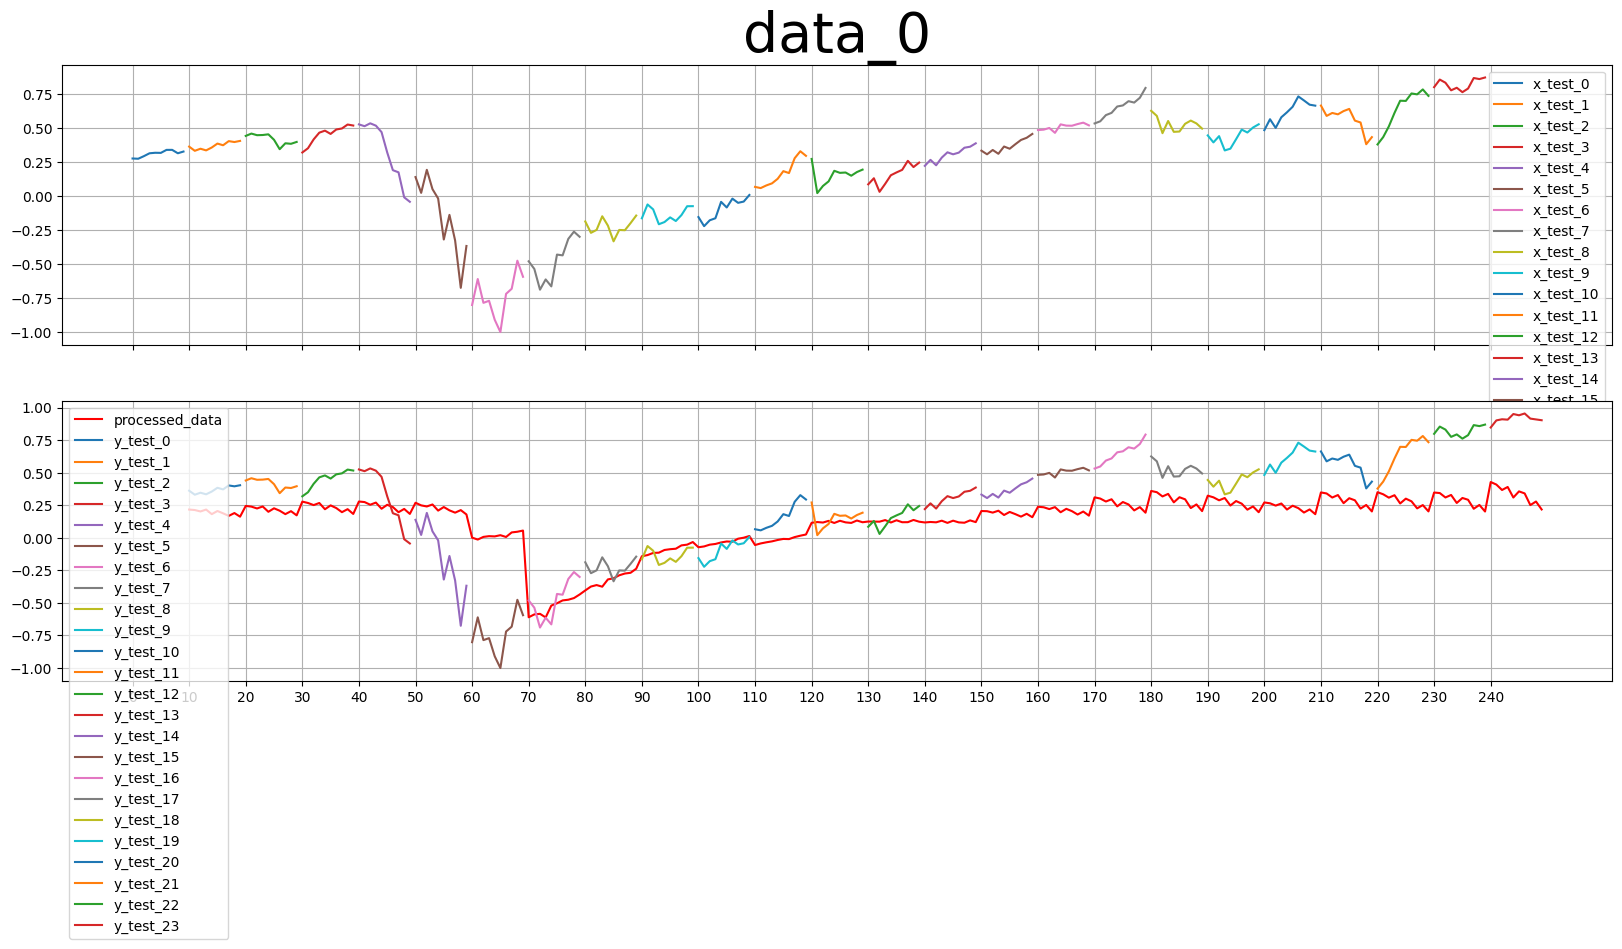

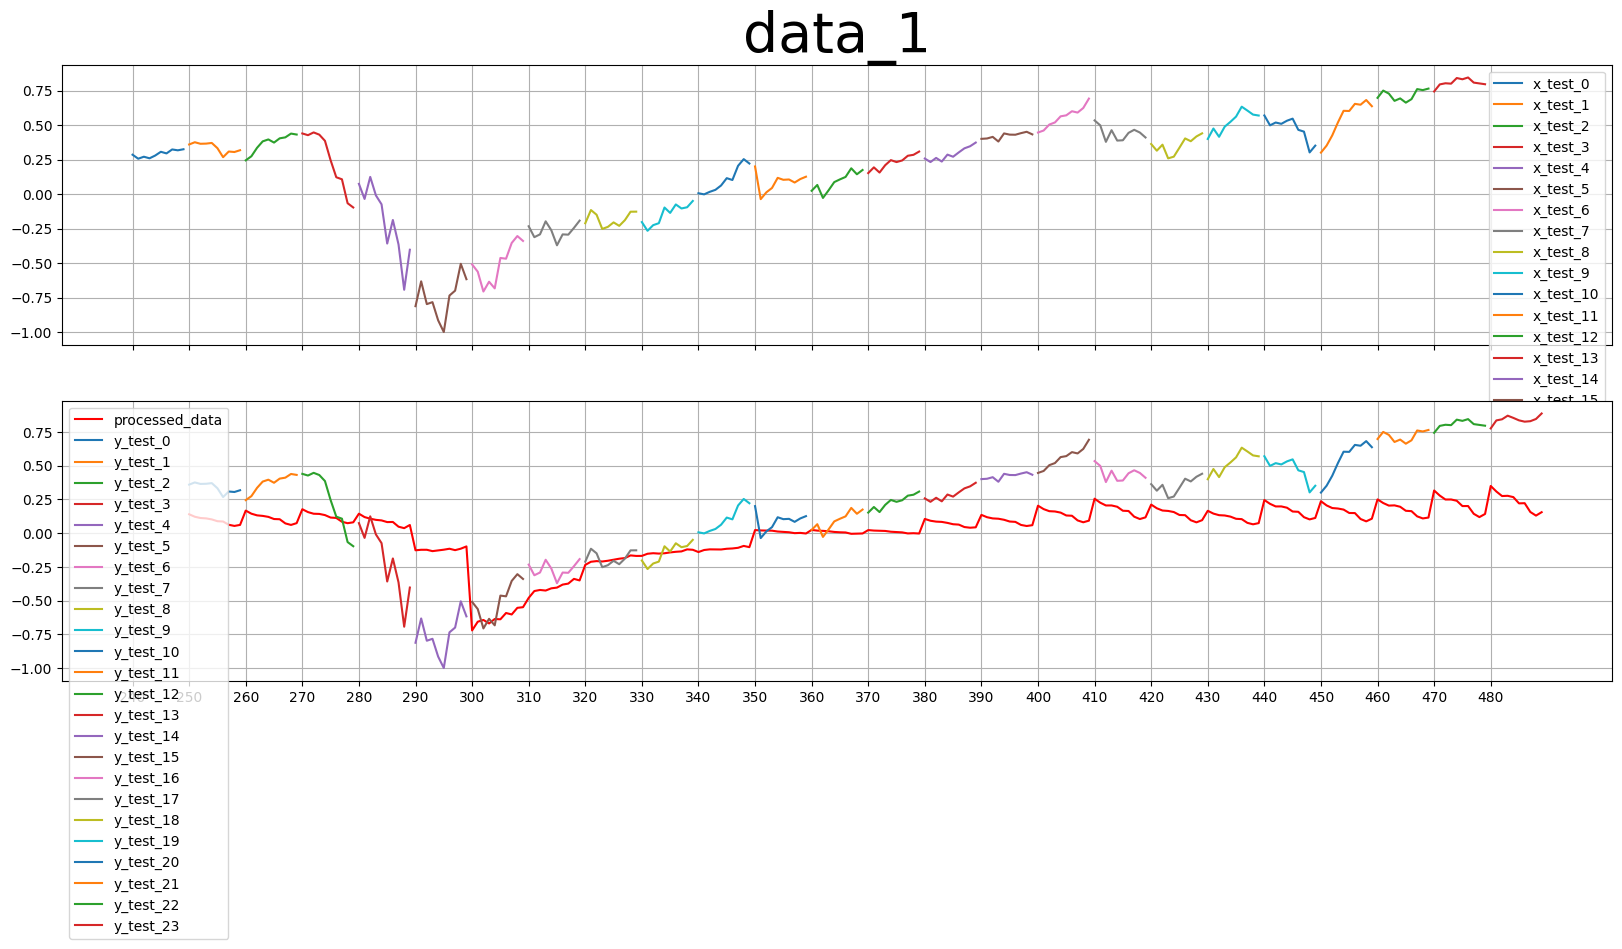

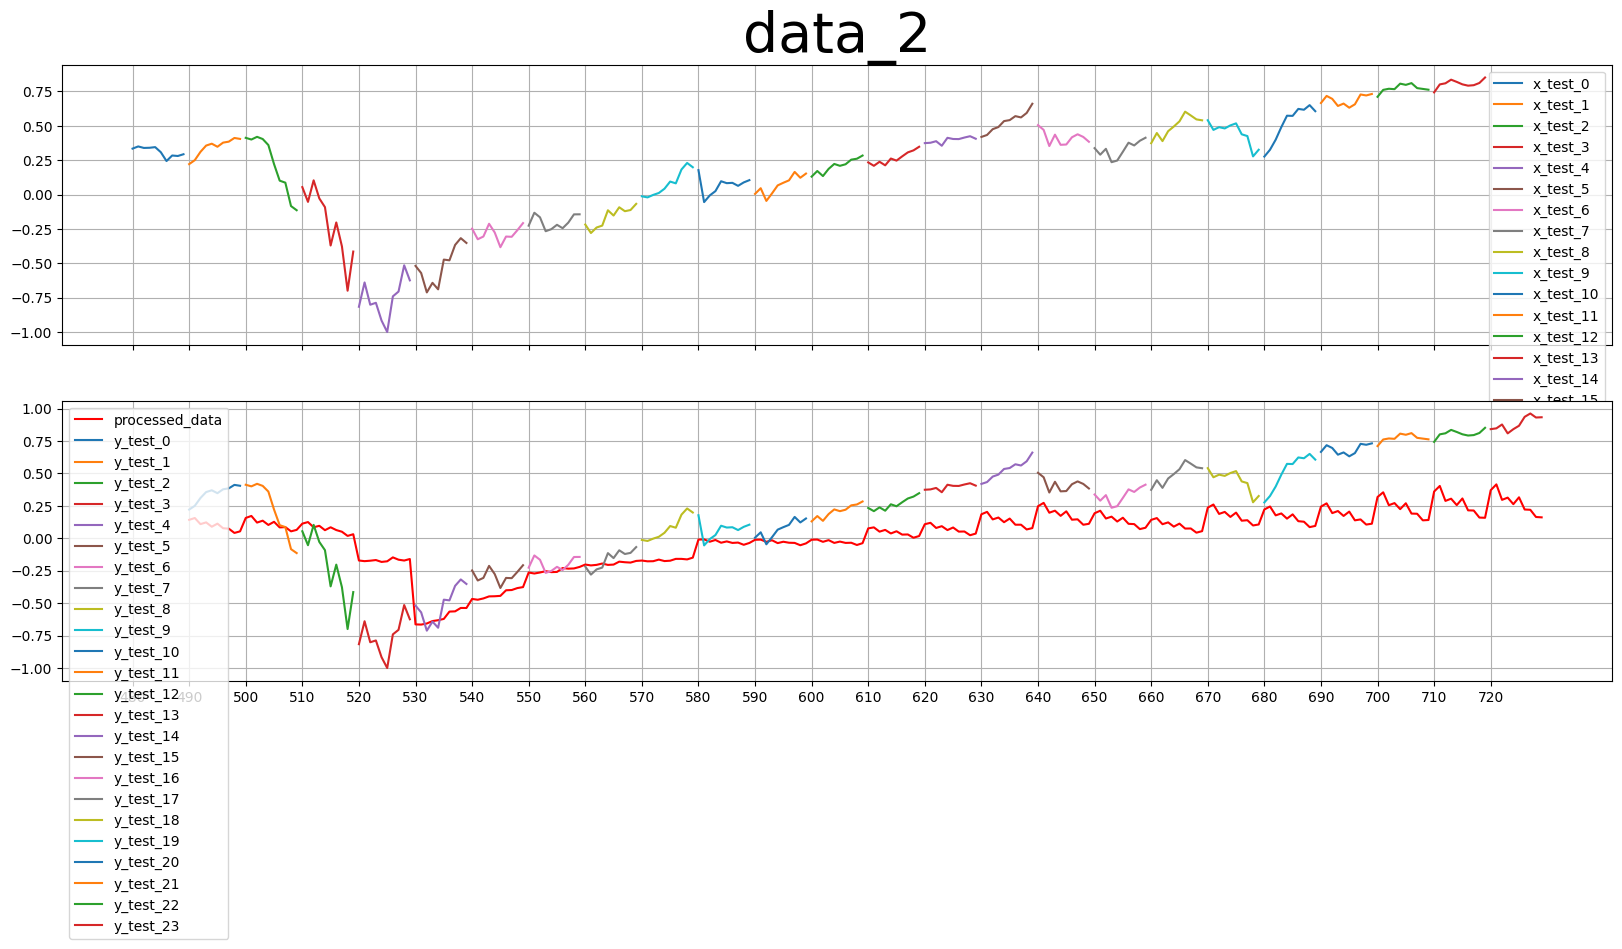

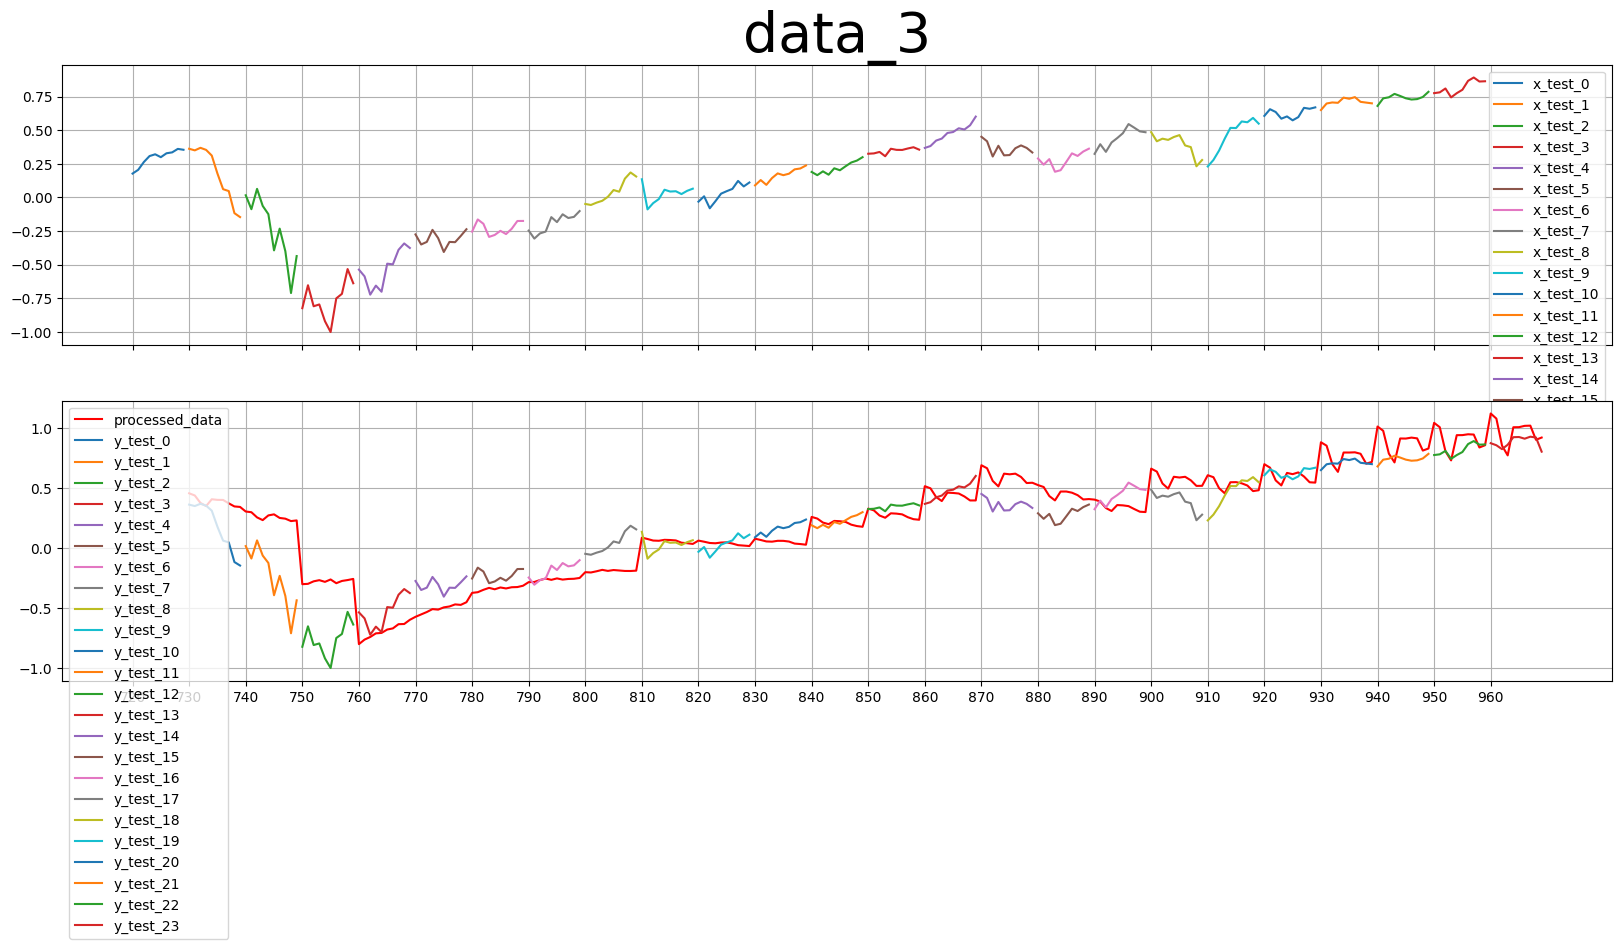

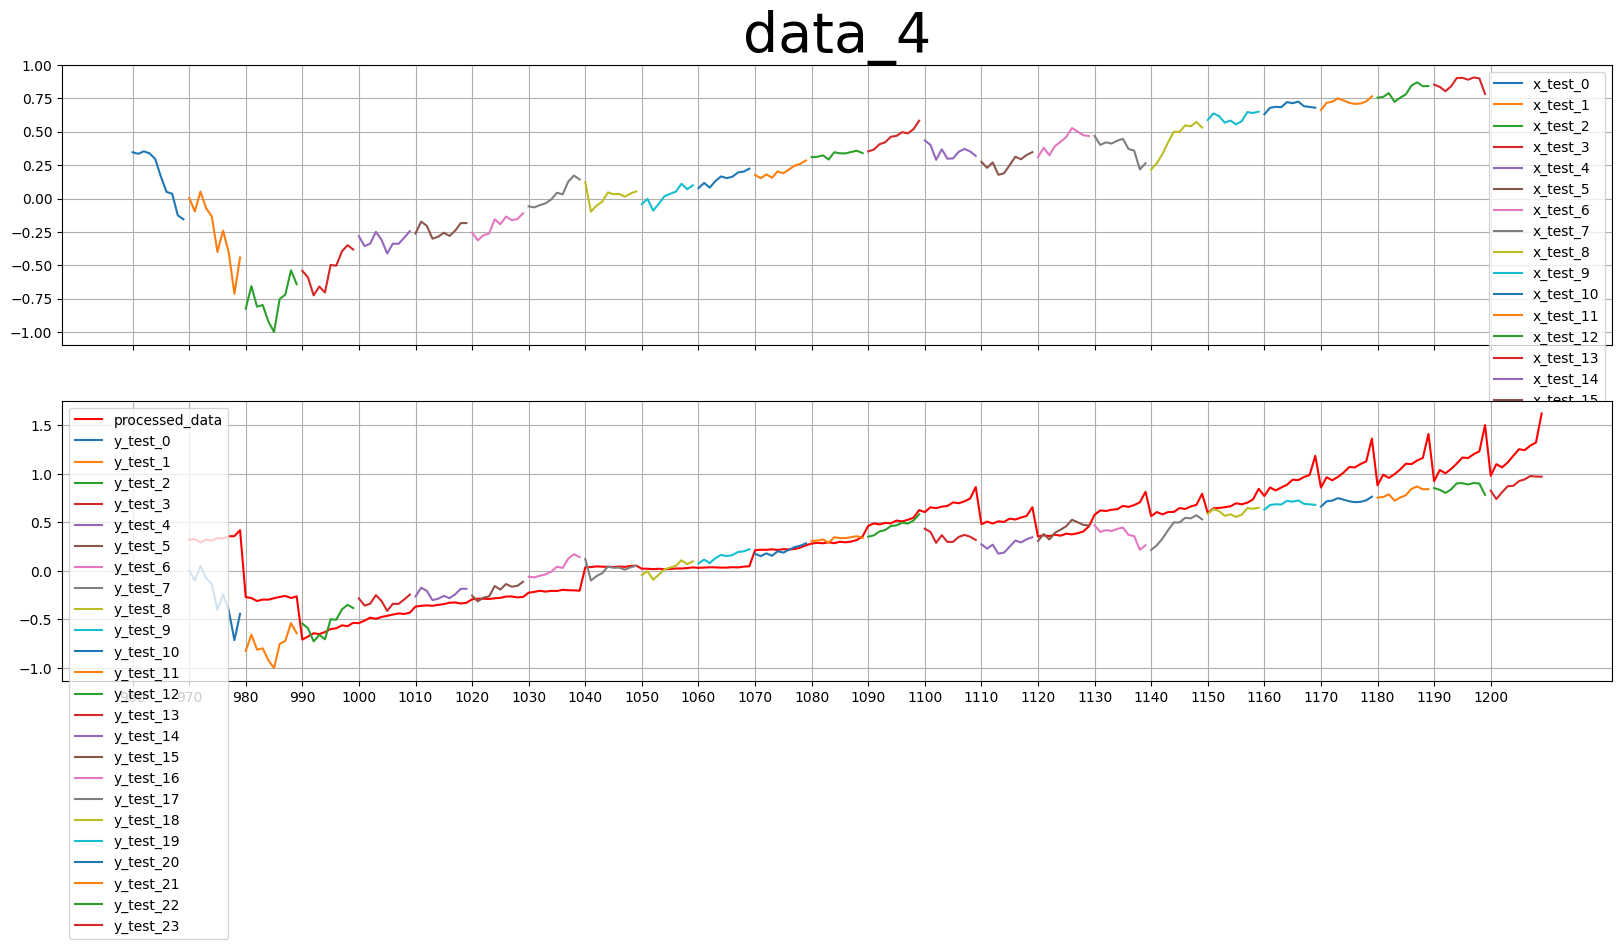

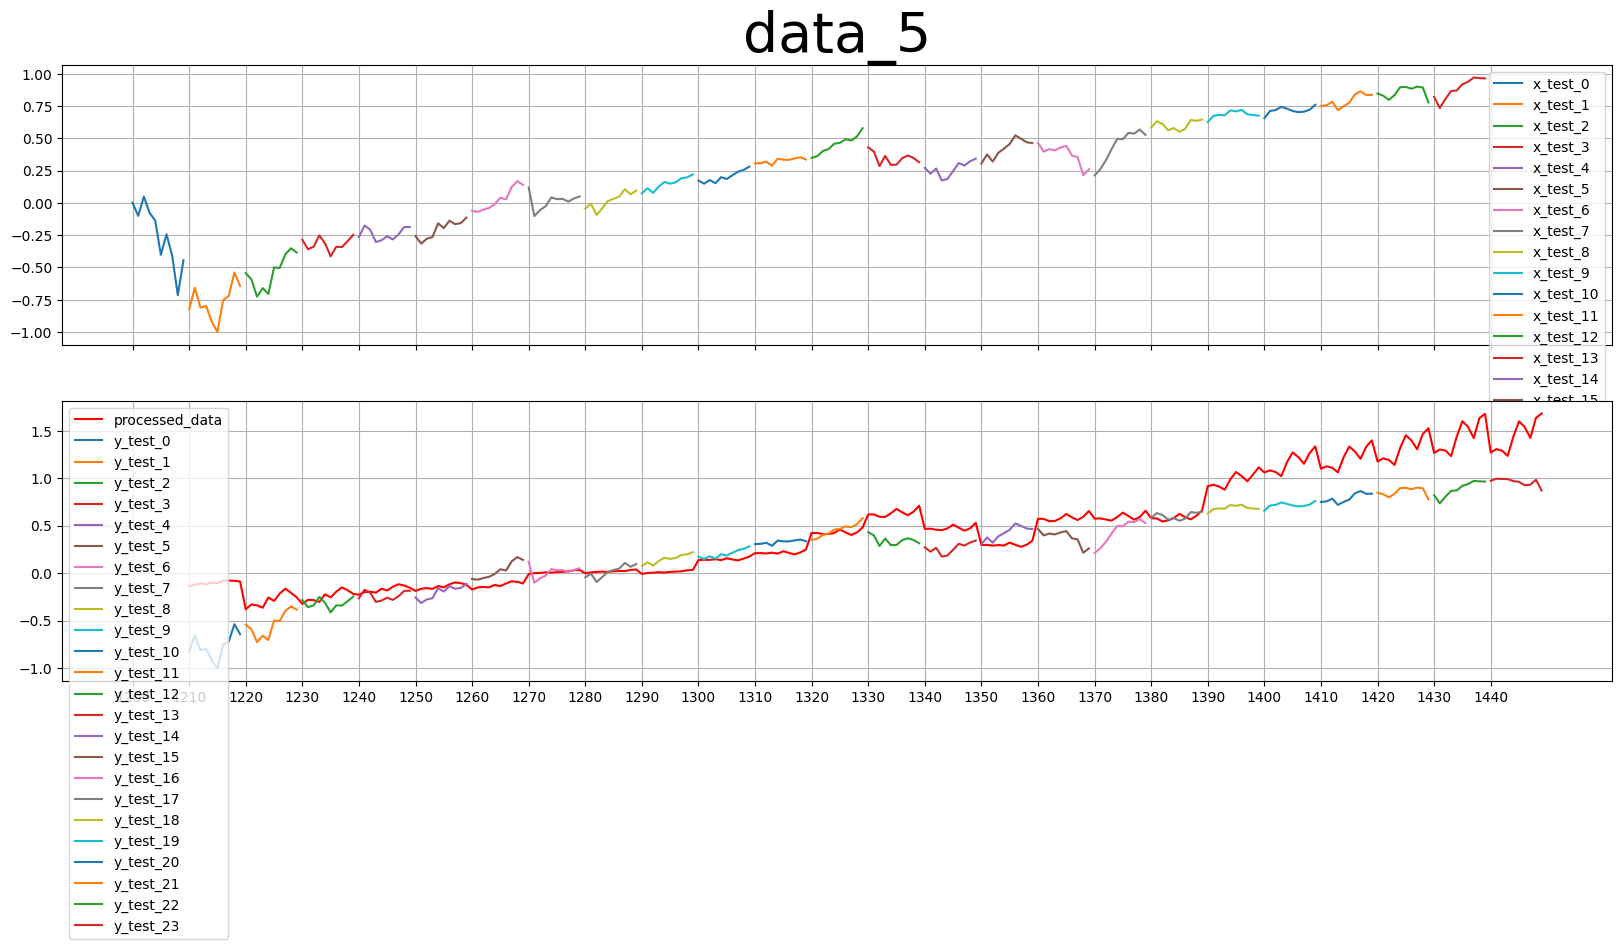

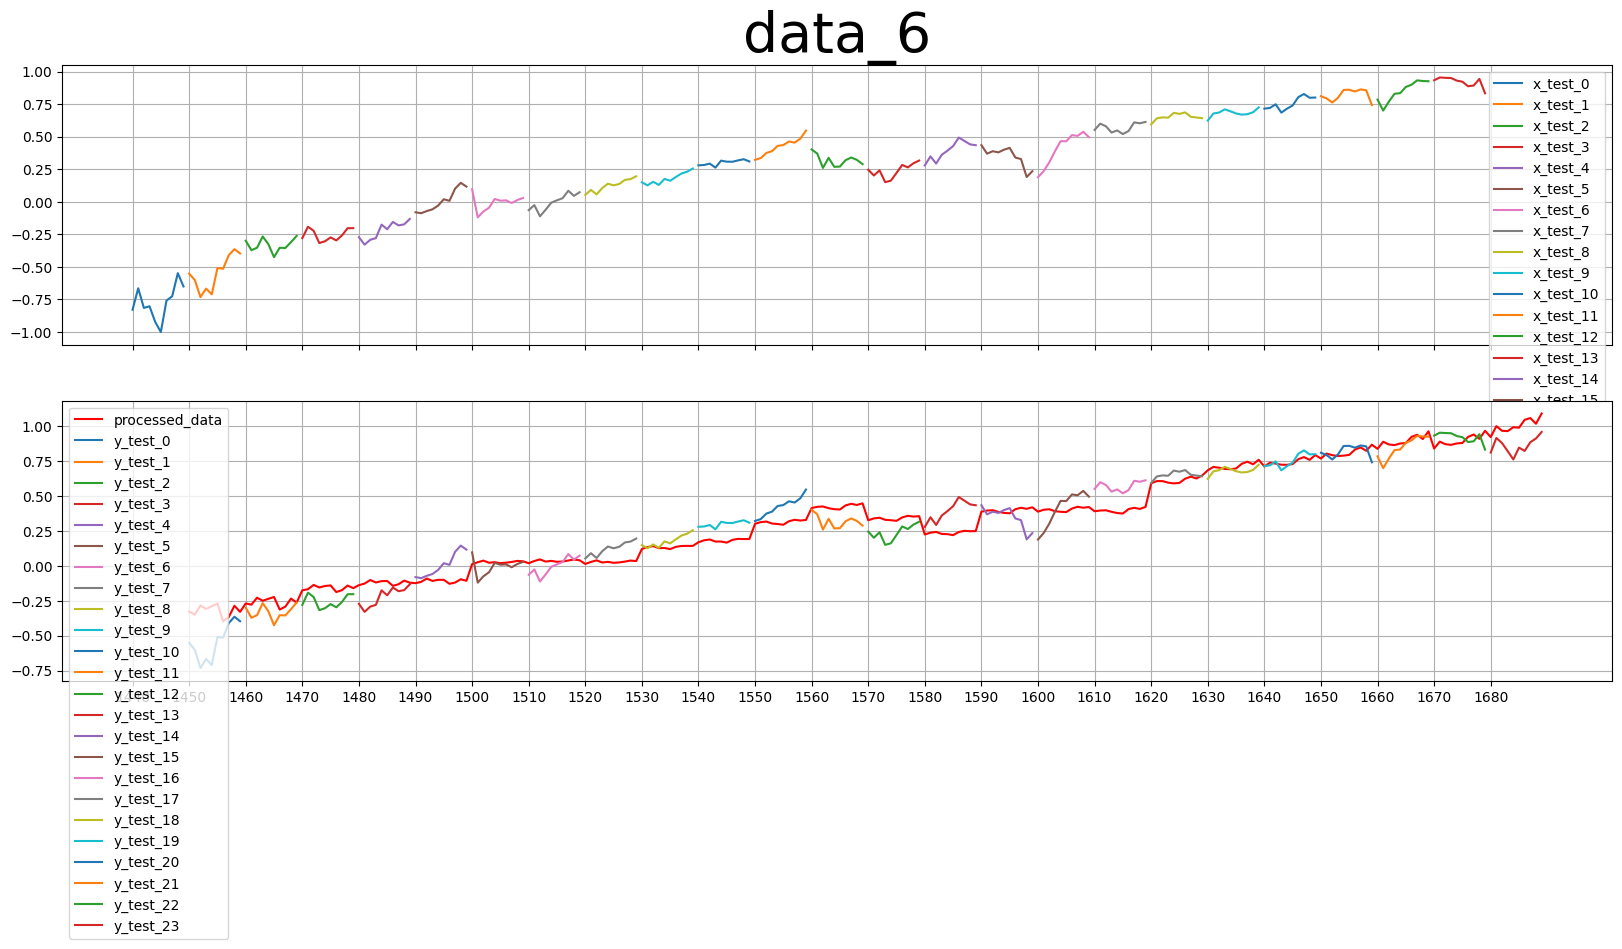

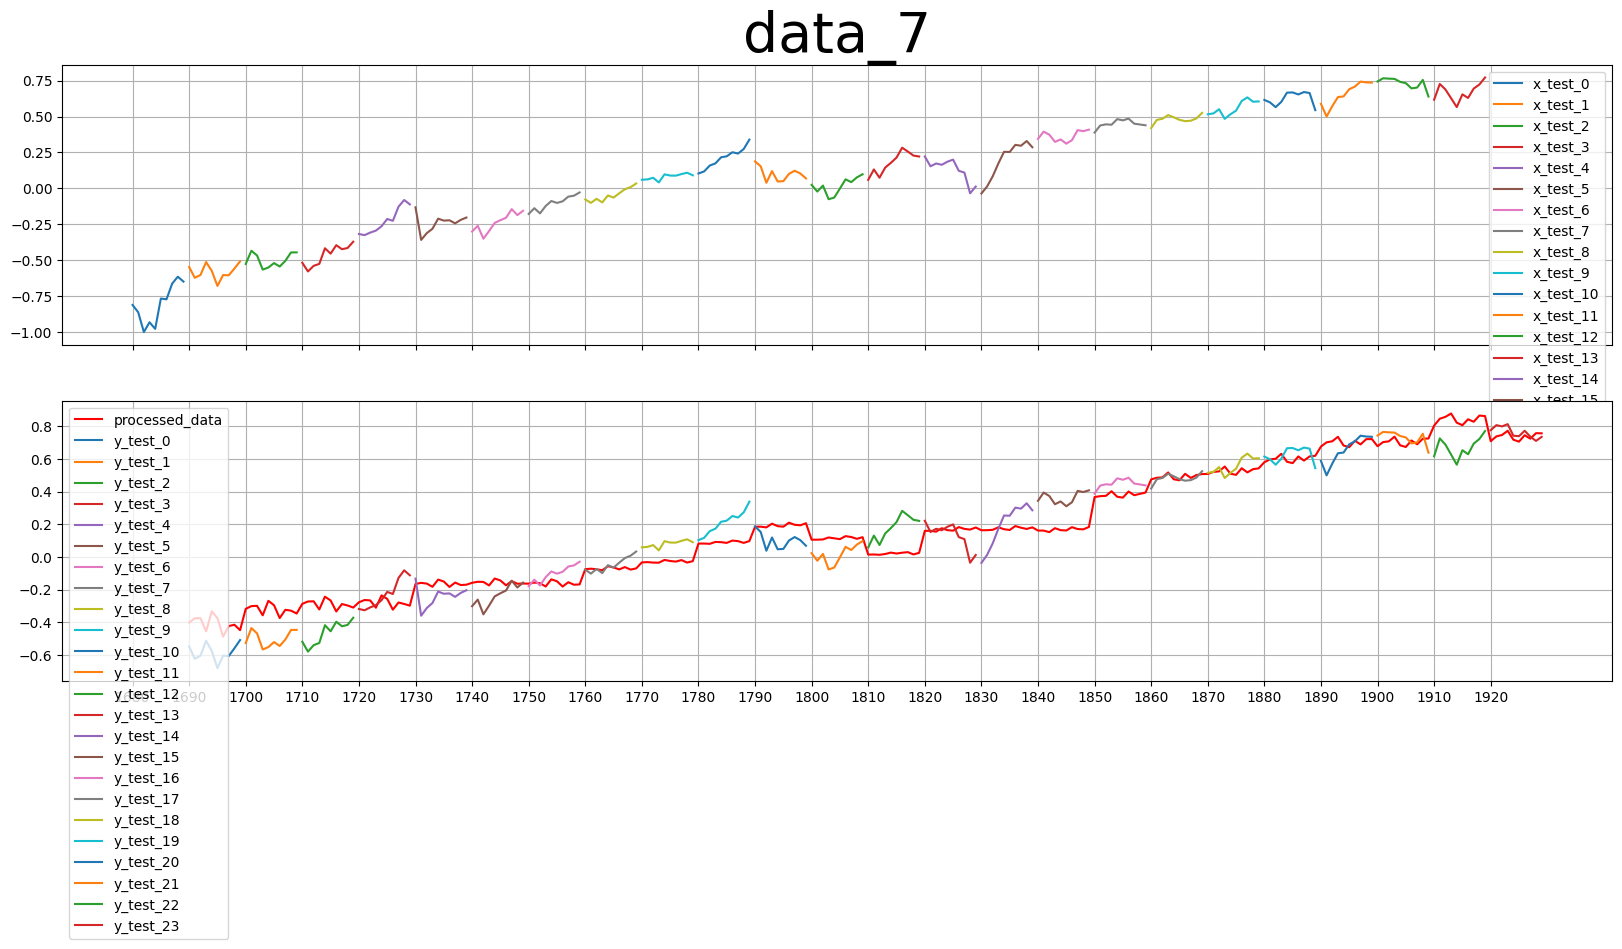

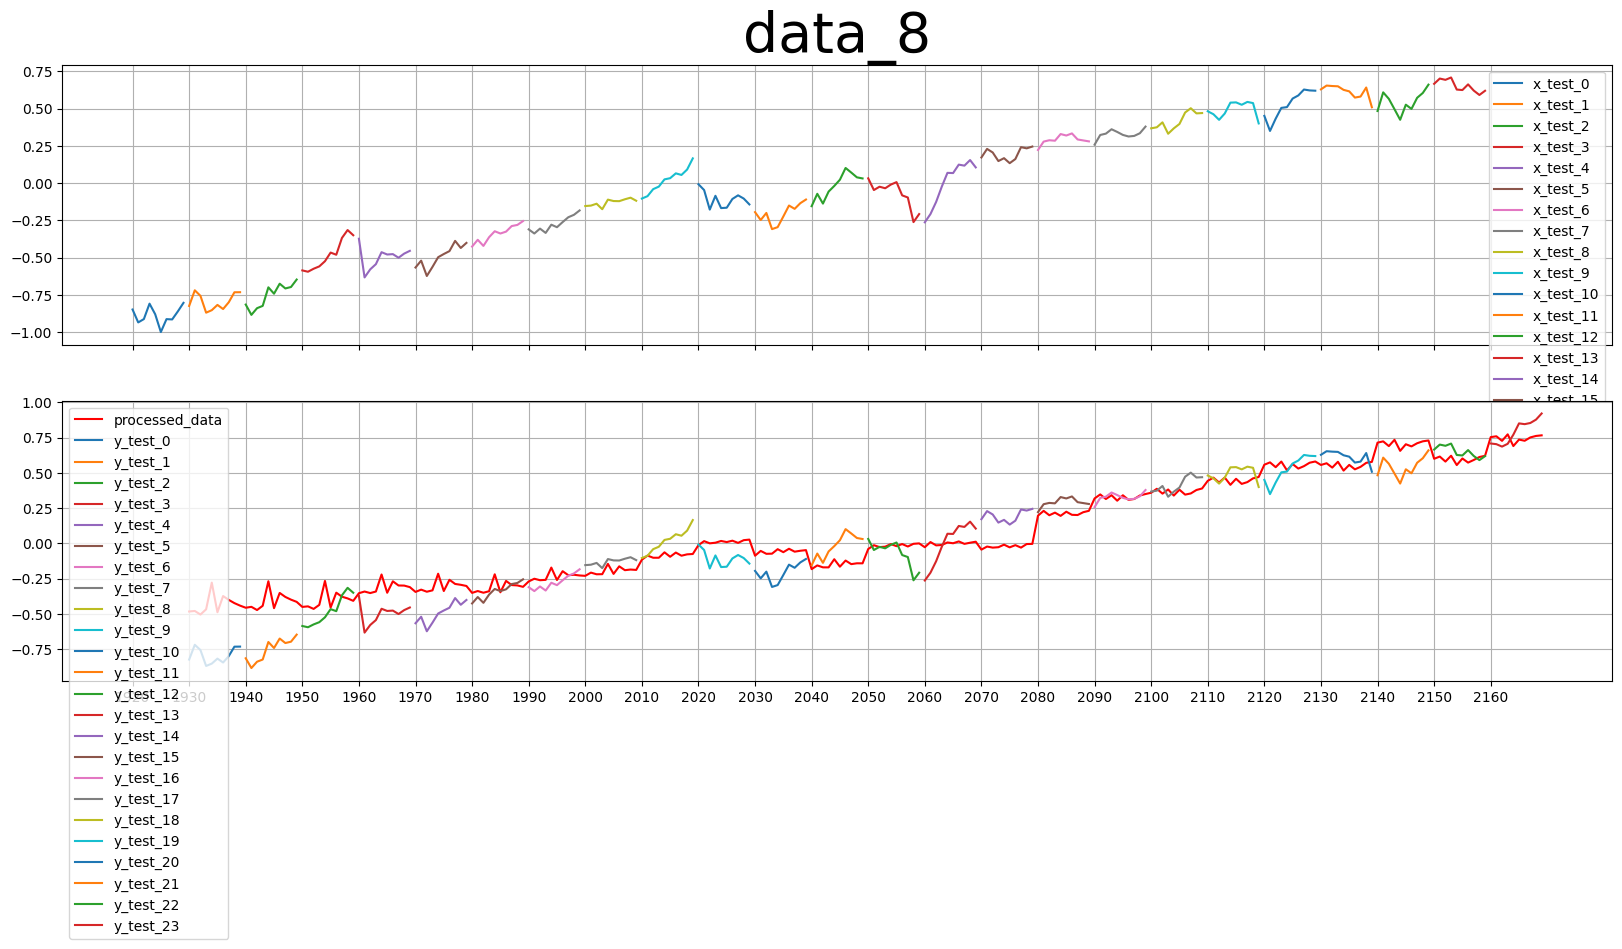

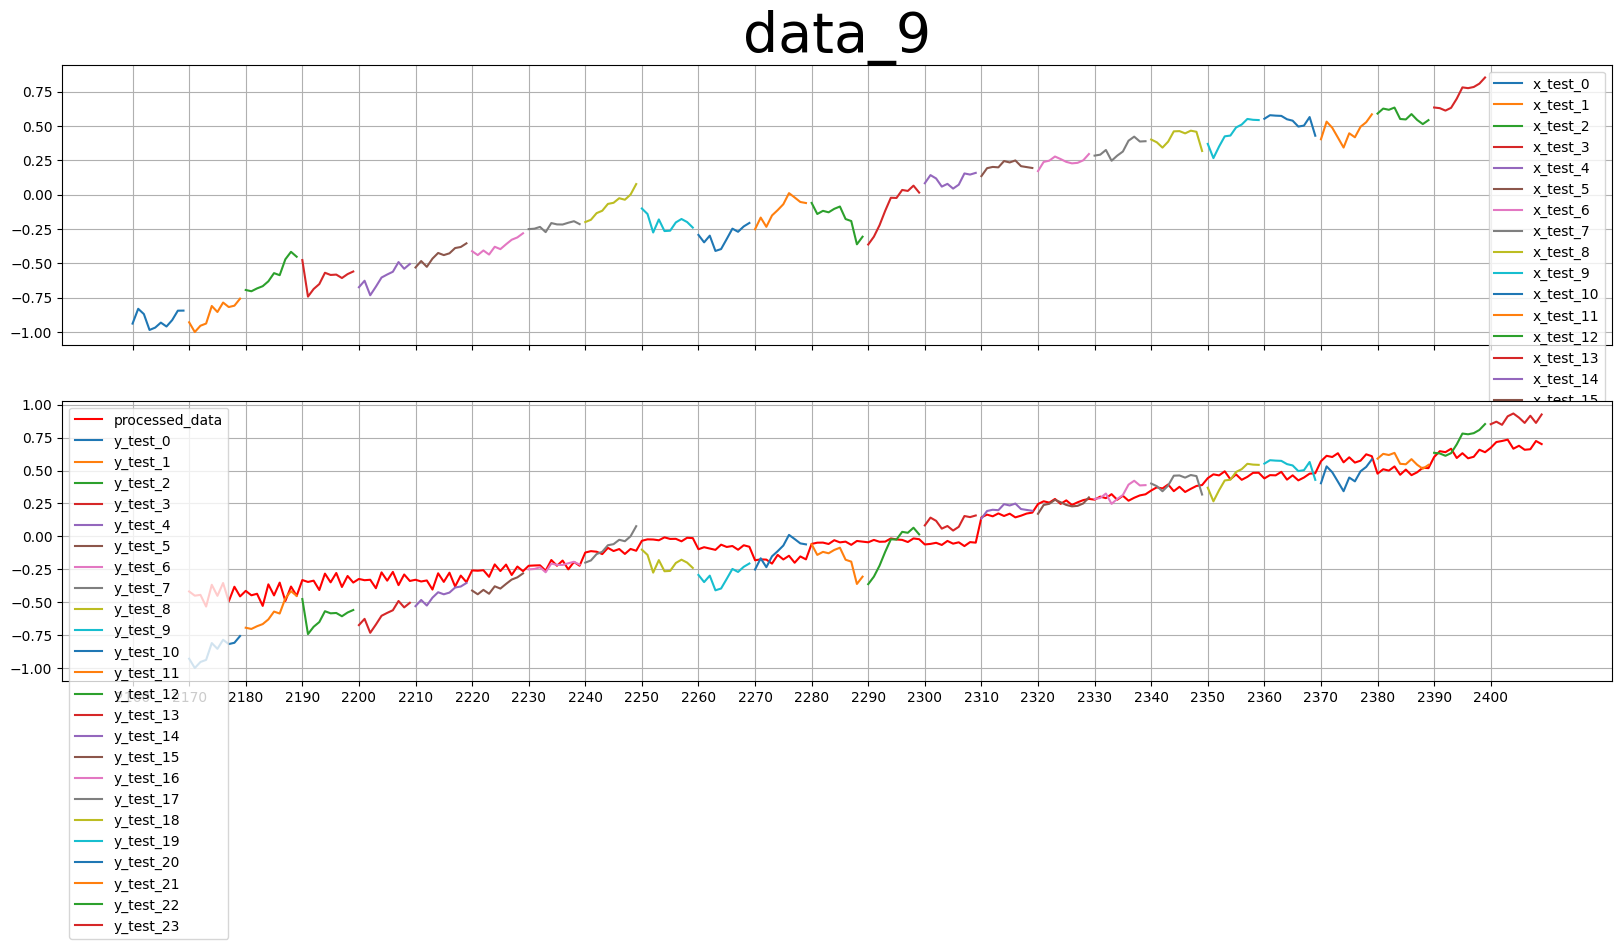

In [70]:
x_start = 0
x_end = x_start+slide
for i in x_test:
    x_start_copy = x_start
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    plot_processed_data = processed_signal[i][0]['Close'].values
    axes[1].plot(range(x_end, x_end+len(plot_processed_data)), plot_processed_data, 'r',label=f'processed_data')
    for j in range(0, x_test[i].shape[0]):
        axes[0].plot(range(x_start, x_end), x_test[i][j], label=f'x_test_{j}')
        axes[1].plot(range(x_end, x_end+slide), y_test[i][j], label=f'y_test_{j}')
        x_start+=slide
        x_end+=slide
    
    axes[0].grid()
    axes[1].grid()
    axes[0].legend()
    axes[1].legend()
    plt.xticks(np.arange(x_start_copy, x_end, step=10))
    plt.show()